<a href="https://www.kaggle.com/code/abhirupghosh184098/ts-forecasting-a-beginner-s-handbook?scriptVersionId=113128391" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Competition: [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting)

## [Short Description](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview/description) (and Disclaimer)

This is a “getting started” competition, where we use time-series forecasting to forecast store sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer. I used the [Time Series course on Kaggle](https://www.kaggle.com/learn/time-series) to help me get started, and a lot of the code in this notebook is from that course, which in turn, are inspired by winning solutions from past Kaggle time series forecasting competitions.

## [Evaluation](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview/evaluation)
The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

The RMSLE is calculated as:
$[\sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2}]$
where:

𝑛 is the total number of instances,  
𝑦̂ 𝑖 is the predicted value of the target for instance (i),  
𝑦𝑖 is the actual value of the target for instance (i), and,  
log is the natural logarithm.

## [Data](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data)

### Training data: train.csv

* The training data, comprising time series of features **store_nbr**, **family**, and **onpromotion** as well as the target **sales**.
* **store_nbr** identifies the store at which the products are sold.
* **family** identifies the type of product sold.
* **sales** gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
* **onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.


### Test data: test.csv

* The test data, having the same features as the training data. You will predict the target **sales** for the dates in this file. 
* The dates in the test data are for the 15 days after the last date in the training data.


### Submission file: sample_submission.csv
A sample submission file in the correct format.

### Additional information
#### 1. Store metadata: stores.csv
  * Store metadata, including **city**, **state**, **type**, and **cluster**.
  * **cluster** is a grouping of similar stores.

#### 2. Daily oil price: oil.csv 
Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

#### 3. Holidays and Events, with metadata: holidays_events.csv
  * NOTE: Pay special attention to the **transferred** column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
  * Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).


### Additional Notes
* Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
* A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


# Preliminaries

## Dependencies

In [2]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.time_series.ex4 import *
import datetime

# Setup notebook
from pathlib import Path
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import (seasonal_plot,
                                          plot_periodogram,
                                          make_lags,
                                          make_leads,
                                          plot_lags,
                                          make_multistep_target,
                                          plot_multistep)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder

# Model 1 (trend)
from pyearth import Earth
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

## Competition Data

In [3]:
comp_dir = Path('../input/store-sales-time-series-forecasting')

# Training data: train.csv

# For the first part of the analysis (time-dependence), we are going to
# use a restricted training data, using information about the store number,
# family, date and the sales; we will use the rest of the training data
# as we expand the analysis.
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

# Holidays and Events, with metadata
holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

# Test data: test.csv
df_test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [4]:
print("Training Data", "\n" + "-" * 13 + "\n", store_sales)
print("\n")
print("Test Data", "\n" + "-" * 9 + "\n", df_test)

Training Data 
-------------
                                      sales
store_nbr family     date                 
1         AUTOMOTIVE 2013-01-01   0.000000
                     2013-01-02   2.000000
                     2013-01-03   3.000000
                     2013-01-04   3.000000
                     2013-01-05   5.000000
...                                    ...
9         SEAFOOD    2017-08-11  23.830999
                     2017-08-12  16.859001
                     2017-08-13  20.000000
                     2017-08-14  17.000000
                     2017-08-15  16.000000

[3000888 rows x 1 columns]


Test Data 
---------
                                       id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08-17  3002670            0
                     2017-08-18  3004452            0
                     2017-08-19  3006234            0
                     2017-08-20  30

# Exploratory Data Analysis (EDA)

In [5]:
store_sales.head()

sales
store_nbr family     date             
1         AUTOMOTIVE 2013-01-01    0.0
                     2013-01-02    2.0
                     2013-01-03    3.0
                     2013-01-04    3.0
                     2013-01-05    5.0

### Indices

#### Date

In [6]:
print("Total duration of data:")
print(f"    Training data: {store_sales.index.get_level_values(2).min()} -- {store_sales.index.get_level_values(2).max()}")
print(f"    Test data: {df_test.index.get_level_values(2).min()} -- {df_test.index.get_level_values(2).max()}")


Total duration of data:
    Training data: 2013-01-01 -- 2017-08-15
    Test data: 2017-08-16 -- 2017-08-31


This amounts to slightly more than 4.5 years (55 months) of training data, followed by the next 15 days to test our model on.

#### Family

The products in the training data belong to different families.

In [7]:
print(f"Total number of families: {len(store_sales.index.unique(level=1))}")

print(f"First 5 families (in alphabetical order): {[x.capitalize() for x in store_sales.index.unique(level=1)[:5]]}")

print(f"Last 5 families (in alphabetical order): {[x.capitalize() for x in store_sales.index.unique(level=1)[-5:]]}")

Total number of families: 33
First 5 families (in alphabetical order): ['Automotive', 'Baby care', 'Beauty', 'Beverages', 'Books']
Last 5 families (in alphabetical order): ['Poultry', 'Prepared foods', 'Produce', 'School and office supplies', 'Seafood']


#### Stores

In [8]:
print(f"Total number of stores: {len(store_sales.index.unique(level=0))}")

Total number of stores: 54


#### TL;DR: Data Summary

There are 1782 time series in this data, distributed between 54 stores and 33 families of products.

# Modelling time dependence

As we learnt in the [Time Series course on Kaggle](https://www.kaggle.com/learn/time-series), there are 2 essential components of a time-series:
* **Time dependence** that leads to two key featues: [Trends](https://www.kaggle.com/code/ryanholbrook/trend) and [Seasonality](https://www.kaggle.com/code/ryanholbrook/seasonality)
* **Serial depencdence** that leads to [cycles](https://www.kaggle.com/code/ryanholbrook/time-series-as-features), and can be explored through lag features.

Each of these features are worth exploring one-by-one in detail. We are goinig to follow the lead of the tutorial in realising that a single machine learning algorithm might not be best-suited to capture all these independent components. While regression algorithms are better for detrending/deseasonalising, [serial dependence is best explored through **decision trees**](https://www.kaggle.com/code/ryanholbrook/time-series-as-features). Hence, getting the best of both worlds, we are going to explore [Hybrid models](https://www.kaggle.com/code/ryanholbrook/hybrid-models) that employ a combination of the above algorithms.

## Trends

As defined in [Time Series course on Kaggle](https://www.kaggle.com/code/ryanholbrook/trend) course, the **trend** component of a time series represents a persistent, long-term change in the mean of the series. The trend is the slowest-moving part of a series, the part representing the largest time scale of importance.

The training set has information that drills down to different levels of detail, eg, store number, product family, etc. At the highest-level, we start looking at trends in the time-dependence of average sales.

In [9]:
average_sales = store_sales.groupby('date').mean()['sales']
average_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
Freq: D, Name: sales, dtype: float32

Calculating a year-long moving average smoothens out short-term fluctuations in the series retaining only long-term changes. With this, we see a year-on-year growth in the average sales.

In [10]:
# moving average plot of average_sales estimating the trend

trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

## Cover graphic

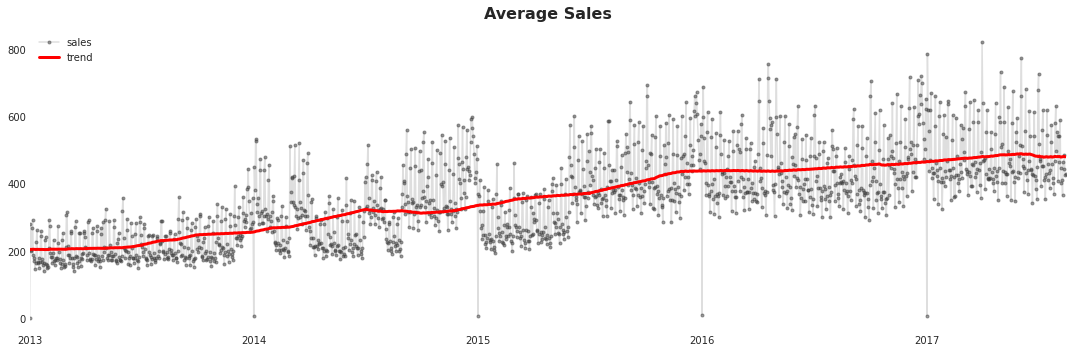

In [11]:
fig, ax = plt.subplots(figsize=(15,5))
average_sales.plot(**plot_params, alpha=0.5, title="Average Sales", ax=ax)
trend.plot(linewidth=3, label='trend', color='r', ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(False)
ax.legend();
ax.set_xlabel("")
plt.savefig('thumbnail_graphic.png', dpi=300)

### First prediction: based on trend

At this point, we attempt to make our first prediction, just using the trend of first, the average sales, and then each family at a time. As we have already seen in the previous plot, the average sales show a year-on-year growth which can be approximated using a linear regression. The polynomial we fit to the sales is our choice, and we will use orders 1 and 3 to see their effects on the prediction. We use the `DeterministicProcess` function to create a feature set for a trend model.

#### Polynomial order: 1

In [12]:
# the target

y = average_sales.copy()
y.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
Freq: D, Name: sales, dtype: float32

In [13]:
# Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend): linear trend
    drop=True,           # drop terms if necessary to avoid collinearity
)

# YOUR CODE HERE: Create the feature set for the dates given in y.index
X = dp.in_sample()

X.head()

,const,trend
date,,
2013-01-01,1.0,1.0
2013-01-02,1.0,2.0
2013-01-03,1.0,3.0
2013-01-04,1.0,4.0
2013-01-05,1.0,5.0


As is standard for evaluating machine learning models, we split our training data into a training set and a validation set. We use the training set to train the model and evaluate its performance on the validation set. In this case, we choose our validation set to be the same size as the actual test set (15 days), and we choose it to be the last 15 days of the original training set. This is to resemble the test set which is 15 days from the end of the training data. 

**[Evaluation](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview/evaluation):** We use the same metric for evaluating performance on the validation set as will be used for the actual test set, namely, the Root Mean Squared Logarithmic Error, calculated as:

$[\sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2}]$

where:

𝑛 is the total number of instances,  
𝑦̂ 𝑖 is the predicted value of the target for instance (i),  
𝑦𝑖 is the actual value of the target for instance (i), and,  
log is the natural logarithm.

Training RMSLE: 0.32472
Validation RMSLE: 0.18144


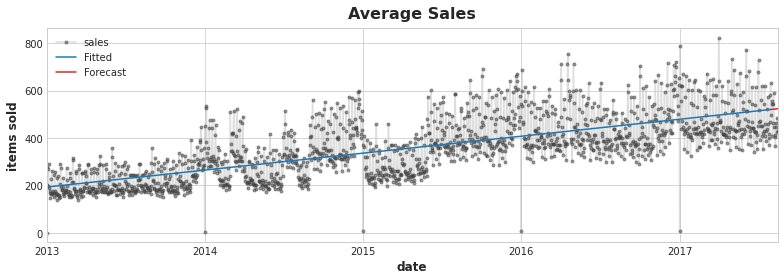

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=15, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend();

#### Polynomial order: 3

In [15]:
# Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=3,             # the time dummy (trend): cubic trend
    drop=True,           # drop terms if necessary to avoid collinearity
)

# YOUR CODE HERE: Create the feature set for the dates given in y.index
X = dp.in_sample()

X.head()

,const,trend,trend_squared,trend_cubed
date,,,,
2013-01-01,1.0,1.0,1.0,1.0
2013-01-02,1.0,2.0,4.0,8.0
2013-01-03,1.0,3.0,9.0,27.0
2013-01-04,1.0,4.0,16.0,64.0
2013-01-05,1.0,5.0,25.0,125.0


Training RMSLE: 0.32328
Validation RMSLE: 0.14174


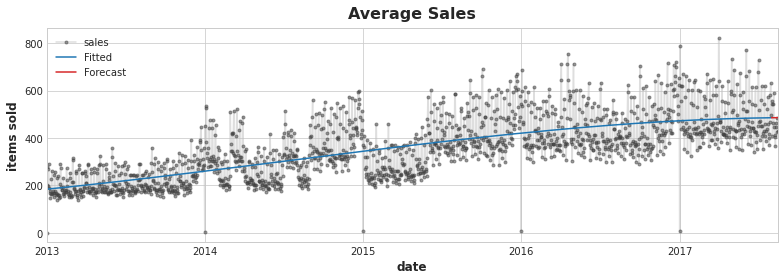

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=15, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend();

We see that the cubic polynomial performs about the same on the training data, but generalises better to the validation set. We will retain the cubic trend for the remainder of this analyses.

#### Average sales vs Per Item sales

In practise, each family of items can have its own trends; and the resulting trend is expected to be their combination. We use this information to redefine our target sales in terms of the data **and family**, instead of averaging over the latter as previously. From there on, we follow the exact procedure with `DeterministicProcess` as we did for the `average_sales` in order to compute the resultant cubic trend of each family; and evaluate our performance on the validation set.

In [17]:
y = store_sales.unstack(['store_nbr', 'family'])  # the target
y.head()

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0   470.652008   
2013-01-03        3.0       0.0    0.0     919.0   0.0   310.654999   
2013-01-04        3.0       0.0    3.0     953.0   0.0   198.365997   
2013-01-05        5.0       0.0    3.0    1160.0   0.0   301.057007   

                                                    ...                        \
store_nbr                                           ...         9               
family     CELEBRATION CLEANING  DAIRY        DELI  ... MAGAZINES       MEATS   
date                                                ...                         
2013-01-01         0.0      0.0    0.0    0.000000  ...       0.0    0.000000   
2013-01-02         0.0   1060.0  579.0  164.069000  ...       0.0  374.531006   
2013-01-03         0.0    836.0  453.0  151.582001  ...       0.0  400.863007   
2013-01-04         0.0    827.0  460.0  131.410995  ...       0.0  310.877991   
2013-01-05         0.0    811.0  464.0  118.612999  ...       0.0  447.684998   

                                                                           \
store_nbr                                                                   
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS     POULTRY   
date                                                                        
2013-01-01           0.0          0.0                     0.0    0.000000   
2013-01-02         482.0          0.0                     0.0  651.291992   
2013-01-03         372.0          0.0                     0.0  509.496002   
2013-01-04         324.0          0.0                     0.0  332.671997   
2013-01-05         461.0          0.0                     0.0  510.919006   

                                                                         
store_nbr                                                                
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date                                                                     
2013-01-01            0.0     0.0                        0.0   0.000000  
2013-01-02           83.0     0.0                        0.0  29.214001  
2013-01-03           66.0     0.0                        0.0  25.000000  
2013-01-04           57.0     0.0                        0.0  11.000000  
2013-01-05           84.0     0.0                        0.0  28.361000  

[5 rows x 1782 columns]

In [18]:
# Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=3,             # the time dummy (trend): cubic trend
    drop=True,           # drop terms if necessary to avoid collinearity
)

# YOUR CODE HERE: Create the feature set for the dates given in y.index
X = dp.in_sample()

X.head()

,const,trend,trend_squared,trend_cubed
date,,,,
2013-01-01,1.0,1.0,1.0,1.0
2013-01-02,1.0,2.0,4.0,8.0
2013-01-03,1.0,3.0,9.0,27.0
2013-01-04,1.0,4.0,16.0,64.0
2013-01-05,1.0,5.0,25.0,125.0


In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=15, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y_train.columns).clip(0.0)
y_pred = pd.DataFrame(model.predict(X_valid), index=X_valid.index, columns=y_valid.columns).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

y_pred.head()

Training RMSLE: 1.08942
Validation RMSLE: 0.59417


sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-08-01   3.989250       0.0  3.531821  2196.628603  0.716912   343.640481   
2017-08-02   3.987273       0.0  3.534058  2196.550189  0.718472   343.374526   
2017-08-03   3.985285       0.0  3.536296  2196.469286  0.720033   343.107744   
2017-08-04   3.983288       0.0  3.538537  2196.385892  0.721597   342.840136   
2017-08-05   3.981282       0.0  3.540779  2196.300004  0.723162   342.571700   

                                                            ...            \
store_nbr                                                   ...         9   
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
date                                                        ...             
2017-08-01   14.867376  652.084491  723.399901  125.146642  ...  3.572239   
2017-08-02   14.857873  651.978731  723.315812  125.079406  ...  3.567129   
2017-08-03   14.848331  651.872595  723.231415  125.011949  ...  3.561989   
2017-08-04   14.838750  651.766082  723.146710  124.944271  ...  3.556819   
2017-08-05   14.829128  651.659192  723.061697  124.876371  ...  3.551620   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-08-01  400.943405    450.827401     8.332957               11.246038   
2017-08-02  400.976549    450.483202     8.338341               11.239880   
2017-08-03  401.009700    450.137935     8.343720               11.233688   
2017-08-04  401.042858    449.791600     8.349094               11.227461   
2017-08-05  401.076023    449.444195     8.354462               11.221199   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-08-01  469.952945     130.385421  1632.064882                   2.883387   
2017-08-02  470.156275     130.457848  1631.080944                   2.857556   
2017-08-03  470.360760     130.530316  1630.091322                   2.831655   
2017-08-04  470.566403     130.602826  1629.096009                   2.805684   
2017-08-05  470.773206     130.675376  1628.094999                   2.779641   

                       
store_nbr              
family        SEAFOOD  
date                   
2017-08-01  16.740531  
2017-08-02  16.732058  
2017-08-03  16.723550  
2017-08-04  16.715008  
2017-08-05  16.706430  

[5 rows x 1782 columns]

Our model seems to generalise well to our validation set. We will use this model to make our first submission and set a baseline for future revisions of our model.

### First submission: based on trends

In [20]:
# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'

X_test.head()

,const,trend,trend_squared,trend_cubed
date,,,,
2017-08-16,1.0,1685.0,2839225.0,4.784094e+09
2017-08-17,1.0,1686.0,2842596.0,4.792617e+09
2017-08-18,1.0,1687.0,2845969.0,4.801150e+09
2017-08-19,1.0,1688.0,2849344.0,4.809693e+09
2017-08-20,1.0,1689.0,2852721.0,4.818246e+09


In [21]:
y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission_trend.csv', index=False)

y_submit.head()

id        sales
date       store_nbr family                          
2017-08-16 1         AUTOMOTIVE  3000888     3.958569
                     BABY CARE   3000889     0.000000
                     BEAUTY      3000890     3.565596
                     BEVERAGES   3000891  2195.189935
                     BOOKS       3000892     0.740510

### [Public Score: 0.63608](https://www.kaggle.com/code/abhirupghosh184098/store-sales-time-series-forecasting?scriptVersionId=111635179)

With the above submission, which only uses trends to make a prediction, we were able to get a RMSLE score of 0.63608. We will slowly improve on the model in iterations.

#### Only 2017 data

One of the reasons we might be doing so much better in the validation set than the training set using just information about trends is that the training set has > 50 months of data points, while the validation and test sets are just a fortnight. It might be worth checking out if trends in the more recent past might be better at predicting the trends of the test period, so as to not be biased by trends which are > 4 years old.

In [22]:
# target sales only in 2017

y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]
y.head()

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2017-01-02        5.0       0.0    0.0    1434.0   0.0   166.819000   
2017-01-03        4.0       0.0    4.0    3081.0   2.0   519.348022   
2017-01-04        1.0       0.0    4.0    3039.0   2.0   543.250977   
2017-01-05        2.0       0.0    3.0    2617.0   0.0   533.479980   

                                                     ...            \
store_nbr                                            ...         9   
family     CELEBRATION CLEANING   DAIRY        DELI  ... MAGAZINES   
date                                                 ...             
2017-01-01         0.0      0.0     0.0    0.000000  ...       0.0   
2017-01-02         0.0    332.0   376.0   44.980000  ...       5.0   
2017-01-03        15.0    952.0  1045.0  209.300003  ...       2.0   
2017-01-04        17.0   1055.0  1029.0  135.944000  ...       3.0   
2017-01-05        40.0    918.0   853.0  137.005997  ...       2.0   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-01-01    0.000000           0.0          0.0                     0.0   
2017-01-02  659.570007        1243.0         11.0                    41.0   
2017-01-03  547.364014         876.0          6.0                    15.0   
2017-01-04  395.287994         677.0          6.0                    13.0   
2017-01-05  470.768005         604.0          7.0                    10.0   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-01-01    0.000000       0.000000     0.000000                        0.0   
2017-01-02  843.596008     115.188995  3136.895996                        1.0   
2017-01-03  714.659973     133.039001  3229.558105                        1.0   
2017-01-04  536.830017      75.201004  1491.416992                        7.0   
2017-01-05  414.100006     113.698997  1566.821045                        1.0   

                    
store_nbr           
family     SEAFOOD  
date                
2017-01-01     0.0  
2017-01-02    23.0  
2017-01-03    14.0  
2017-01-04     0.0  
2017-01-05    17.0  

[5 rows x 1782 columns]

In [23]:
# Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=3,             # the time dummy (trend): cubic trend
    drop=True,           # drop terms if necessary to avoid collinearity
)

# YOUR CODE HERE: Create the feature set for the dates given in y.index
X = dp.in_sample()

X.head()

,const,trend,trend_squared,trend_cubed
date,,,,
2017-01-01,1.0,1.0,1.0,1.0
2017-01-02,1.0,2.0,4.0,8.0
2017-01-03,1.0,3.0,9.0,27.0
2017-01-04,1.0,4.0,16.0,64.0
2017-01-05,1.0,5.0,25.0,125.0


In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=15, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y_train.columns).clip(0.0)
y_pred = pd.DataFrame(model.predict(X_valid), index=X_valid.index, columns=y_valid.columns).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

y_pred.head()

Training RMSLE: 0.62841
Validation RMSLE: 0.56709


sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-08-01   5.349450       0.0  3.344444  2124.133887  0.092436   338.766558   
2017-08-02   5.393372       0.0  3.340316  2119.957001  0.081210   338.736613   
2017-08-03   5.438187       0.0  3.335902  2115.658091  0.069748   338.716315   
2017-08-04   5.483904       0.0  3.331199  2111.235822  0.058048   338.705777   
2017-08-05   5.530532       0.0  3.326201  2106.688860  0.046107   338.705109   

                                                            ...            \
store_nbr                                                   ...         9   
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
date                                                        ...             
2017-08-01   14.902556  645.655768  672.191072  137.821375  ...  2.974365   
2017-08-02   14.858090  644.919083  671.439019  138.216361  ...  2.964886   
2017-08-03   14.812717  644.165706  670.690078  138.623278  ...  2.955491   
2017-08-04   14.766429  643.395464  669.944353  139.042253  ...  2.946182   
2017-08-05   14.719221  642.608187  669.201944  139.473411  ...  2.936964   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-08-01  380.757536    393.289108     8.116384                6.445317   
2017-08-02  380.534249    390.608215     8.109137                6.344014   
2017-08-03  380.309941    387.881987     8.101568                6.242382   
2017-08-04  380.084599    385.110039     8.093675                6.140427   
2017-08-05  379.858211    382.291983     8.085454                6.038155   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-08-01  413.811796     102.347958  1585.752995                  10.281379   
2017-08-02  412.205319     101.846460  1582.088909                  10.531045   
2017-08-03  410.559099     101.340696  1578.336275                  10.785652   
2017-08-04  408.872733     100.830664  1574.494123                  11.045242   
2017-08-05  407.145821     100.316361  1570.561484                  11.309859   

                       
store_nbr              
family        SEAFOOD  
date                   
2017-08-01  14.092199  
2017-08-02  13.898313  
2017-08-03  13.701075  
2017-08-04  13.500466  
2017-08-05  13.296464  

[5 rows x 1782 columns]

Suddenly, our training and validation scores are a lot closer to each other. This comes in the form of a betterment of the training score and a worsening of the validation score. But what it really indicates is that the model generalises a lot better now. 

**We will now use this model to make predictions for the test score.**

In [25]:
# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'

X_test.head()

,const,trend,trend_squared,trend_cubed
date,,,,
2017-08-16,1.0,228.0,51984.0,11852352.0
2017-08-17,1.0,229.0,52441.0,12008989.0
2017-08-18,1.0,230.0,52900.0,12167000.0
2017-08-19,1.0,231.0,53361.0,12326391.0
2017-08-20,1.0,232.0,53824.0,12487168.0


In [26]:
y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission_trend_2017.csv', index=False)

y_submit.head()

id        sales
date       store_nbr family                          
2017-08-16 1         AUTOMOTIVE  3000888     6.105940
                     BABY CARE   3000889     0.000000
                     BEAUTY      3000890     3.250720
                     BEVERAGES   3000891  2048.061053
                     BOOKS       3000892    -0.101825

### [Public Score: 0.75026](https://www.kaggle.com/code/abhirupghosh184098/store-sales-time-series-forecasting?scriptVersionId=111635179)

Restricting our data to just the 2017 data actually worsens our public score to 0.75026. However, our training, validation and test sets still remain comparable (0.62841 / 0.56709 / 0.75026). Hence we will continue restricting ourselves to the 2017 data, and turn to the next feature of the time-series: **Seasonality**.

## Seasonality

While trends represent long-term changes in the mean of the series, [seasonality](https://www.kaggle.com/code/ryanholbrook/seasonality) represents **regular, periodic changes in the mean of the series** caused by weekly, monthly, seasonal or yearly patterns of social behaviour. In this context a season can mean a week, month, year or an actual 'season' (e.g., Vivaldi's "The Four Seasons"). However, depending on the number of observations in a season, we might use **two distinct features** to model seasonality:

* [Seasonal indicators](https://www.kaggle.com/code/ryanholbrook/seasonality#Seasonal-Plots-and-Seasonal-Indicators): For a season with few observations (eg, a weekly season of daily observations) seasonal differences in the level of the time series (eg, difference between daily observations in a week) can be represented through binary features, or more specifically, one-hot-encoded categorical features. These features are called **seasonal indicators** and can be represented through seasonal plots.
* [Fourier features](https://www.kaggle.com/code/ryanholbrook/seasonality#Fourier-Features-and-the-Periodogram): Seasonal indicators create a feature for every unit of the period of the season. Hence, they have the tendency to blow up for long seasons, e.g., daily observations over a year. For such cases, we use **Fourier features**, pairs of sine and cosine curves, one pair for each potential frequency in the season starting with the longest, to capture the overall shape of the seasonal curve with just a few features. We can choose these features using a **periodogram** which tells us the strength of the frequencies in a time series.

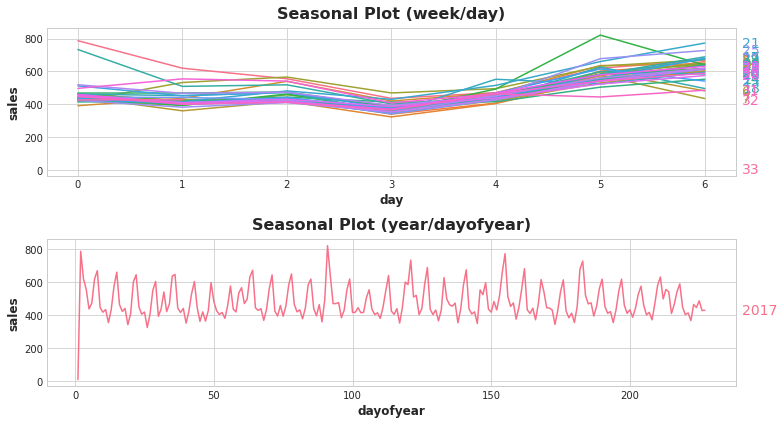

In [27]:
X = average_sales.loc['2017'].to_frame()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax1);

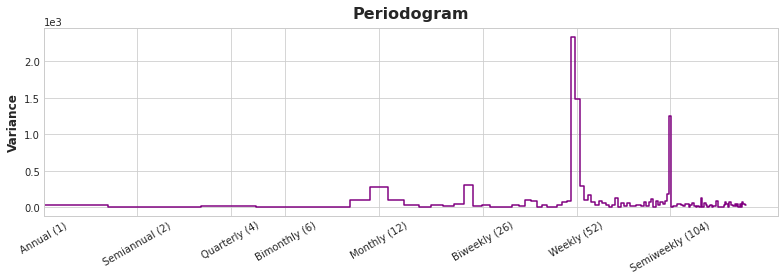

In [28]:
plot_periodogram(average_sales.loc['2017']);

The periodogram tells us the strength of the frequencies in a time series. Specifically, the value on the y-axis of the graph is (a ** 2 + b ** 2) / 2, where a and b are the coefficients of the sine and cosine at that frequency (as in the Fourier Components plot above). From left to right, the periodogram shows appreciating Fourier contributions starting from a monthly frequency. This is followed by a significant biweekly contribution. These two make sense in view of the notes to the Store Sales dataset which mentions that wages in the public sector are paid out biweekly, on the 15th and last day of the month -- a possible origin for these seasons.

Already after these two features, we get down to weekly features which can be described through seasonal indicators.

### Creating seasonal features (also including linear trend)

In [29]:
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

# Fourier features
fourier = CalendarFourier(freq='M', order=4) ## 2 pairs of sine/cosine curves to model monthly/biweekly seasonality
dp = DeterministicProcess(
    index=y.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # cubic trend
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()

In [30]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=15, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y_train.columns).clip(0.0)
y_pred = pd.DataFrame(model.predict(X_valid), index=X_valid.index, columns=y_valid.columns).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

y_pred.head()

Training RMSLE: 0.62390
Validation RMSLE: 0.57367


sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-08-01   5.024247       0.0  3.961651  2244.459247  0.386078   328.939471   
2017-08-02   5.650650       0.0  4.007962  2516.636447  0.532333   414.733731   
2017-08-03   5.837047       0.0  3.110995  2238.215966  0.237725   372.601868   
2017-08-04   7.115996       0.0  2.883839  2529.708792  0.257185   390.066055   
2017-08-05   5.820920       0.0  3.745052  2684.328165  0.022511   414.932839   

                                                            ...            \
store_nbr                                                   ...         9   
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
date                                                        ...             
2017-08-01   16.708611  764.296577  707.892565  145.298258  ...  2.676951   
2017-08-02   18.544272  909.880414  869.799854  154.568826  ...  2.515350   
2017-08-03   22.473153  764.980918  743.352956  131.140133  ...  2.013585   
2017-08-04   23.641936  827.092820  826.990356  184.189444  ...  1.972519   
2017-08-05   15.459501  739.807195  832.194912  156.168208  ...  2.549400   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-08-01  410.867911    595.251327     9.305055               12.322685   
2017-08-02  413.416032    588.718899    11.137383               11.659316   
2017-08-03  608.846824    579.525152     9.400345               11.328414   
2017-08-04  370.036334    514.029295     9.666326                8.955014   
2017-08-05  477.268298    760.911738    11.924145               13.997996   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-08-01  465.343467     121.966481  2491.925546                   7.285770   
2017-08-02  472.092037     112.739250  1478.305034                   5.849904   
2017-08-03  464.411599     107.507712  1492.915948                   5.198424   
2017-08-04  586.320915     104.166719  1433.634030                   4.657719   
2017-08-05  642.131141     158.955689  2034.947663                   5.774444   

                       
store_nbr              
family        SEAFOOD  
date                   
2017-08-01  22.008916  
2017-08-02  20.347534  
2017-08-03  19.328054  
2017-08-04  21.600958  
2017-08-05  30.090346  

[5 rows x 1782 columns]

### Second submission: based on (linear) trends + seasonality

In [31]:
# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'

X_test.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)"
date,,,,,,,,,,,,,,,,
2017-08-16,1.0,228.0,0.0,0.0,1.0,0.0,0.0,0.0,0.101168,-0.994869,-0.201299,0.979530,0.299363,-0.954139,-0.394356,0.918958
2017-08-17,1.0,229.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.101168,-0.994869,0.201299,0.979530,-0.299363,-0.954139,0.394356,0.918958
2017-08-18,1.0,230.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.299363,-0.954139,0.571268,0.820763,-0.790776,-0.612106,0.937752,0.347305
2017-08-19,1.0,231.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.485302,-0.874347,0.848644,0.528964,-0.998717,-0.050649,0.897805,-0.440394
2017-08-20,1.0,232.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.651372,-0.758758,0.988468,0.151428,-0.848644,0.528964,0.299363,-0.954139


In [32]:
y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission_trend_seasonality_2017.csv', index=False)

y_submit.head()

id        sales
date       store_nbr family                          
2017-08-16 1         AUTOMOTIVE  3000888     4.362186
                     BABY CARE   3000889     0.000000
                     BEAUTY      3000890     3.499476
                     BEVERAGES   3000891  2464.821826
                     BOOKS       3000892     0.548516

## [Public Score: 0.58780](https://www.kaggle.com/code/abhirupghosh184098/store-sales-forecasting-a-comprehensive-guide?scriptVersionId=111669039)

We achieve our best score yet by:
* restricting to 2017 data
* assuming a linear trend
* incorporating seasonality through:
  * setting day-of-the-week seasonal indicators
  * fourier features to represent monthly/bi-weekly behaviour (primarily influenced by wage-timings)
  
Before we close the chapter on time-dependence and move on to serial dependence, there is one last piece of information we can add: **information about holidays**.

### Quick digression: Deseasonalising/Detrending

As a quick check of the effectiveness of our seasonality modelling, we can do a **residual analysis**. A residual is what is left behind when we subtract from the data, predictions of our model. If we have done a good job with our model, we are left with a residual that is effectively zero (sans some random fluctuations).

We have several stores and families of products that we detrended/deseasonalised individually. However, for an easy visual representation of the residuals, we once again consider the average sales, this time for just our training set.

In [33]:
y_train_avg = y_train.stack(['store_nbr', 'family']).groupby('date').mean()['sales']
y_fit_avg = y_fit.stack(['store_nbr', 'family']).groupby('date').mean()['sales']
y_deseason_avg = y_train_avg - y_fit_avg

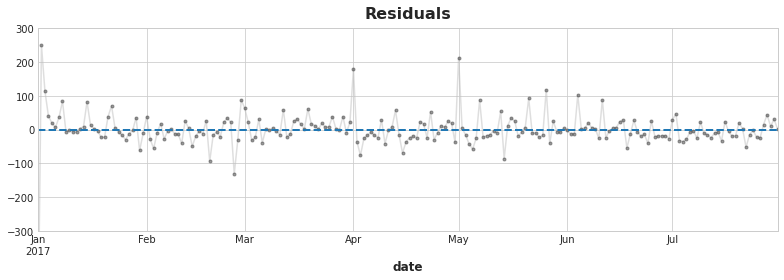

In [34]:
ax = y_deseason_avg.plot(**plot_params, alpha=0.5, ylim=[-300,300], title='Residuals')
ax.axhline(y=0, ls='dashed', lw=2)

We also plot the periodogram of the deseasonalised time series. The previously present monthly/bi-weekly Fourier features should now be absent, if they had been correctly taken care of; and we indeed find that.

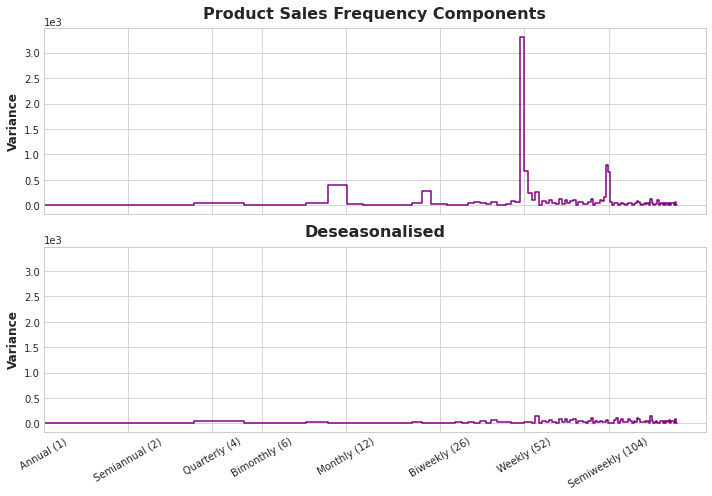

In [35]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y_train_avg, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason_avg, ax=ax2);
ax2.set_title("Deseasonalised");

## Holidays

We had already read-in the "Holidays and Events" dataset at the very beginning. This is what the dataset looks like:

In [36]:
holidays_events.info()
holidays_events.head()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 350 entries, 2012-03-02 to 2017-12-26
Freq: D
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   type         350 non-null    category
 1   locale       350 non-null    category
 2   locale_name  350 non-null    category
 3   description  350 non-null    category
 4   transferred  350 non-null    bool    
dtypes: bool(1), category(4)
memory usage: 10.4 KB


,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


There are 350 entries between 2012-03-02 and 2017-12-26; however, this dataset can be significantly reduced based on prior information and intuition. We can restrict ourselves to:
* holidays in 2017 that fall within our training (2017-01-01 : 2017-07-31) + validation (2017-08-01 : 2017-08-15) + test set (2017-08-16 : 2017-08-31)
* national and regional holidays, ignoring local holidays (assuming a local holiday will have minimum impact on the average national sales)

This reduces the holidays_events dataset to following 14 holidays.

In [37]:
# National and regional holidays in the training set
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']] ## restricting ourselves to the dates in the training set
    .assign(description=lambda x: x.description.cat.remove_unused_categories()) ## remove categories which are not used
)

holidays

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


From a plot of the deseasonalized (training) average sales, it appears these holidays could have some predictive power.

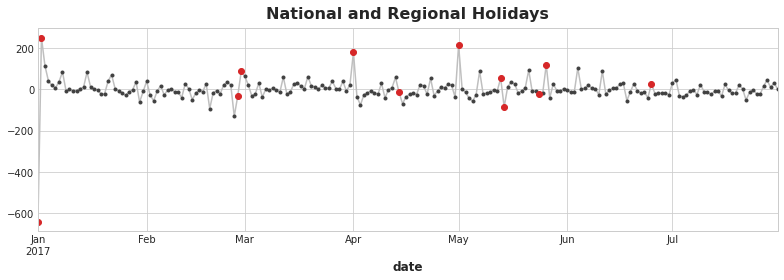

In [38]:
ax = y_deseason_avg.plot(**plot_params)
plt.plot_date(holidays.index[:-2], y_deseason_avg[holidays.index[:-2]], color='C3') # the [:-2] is to remove the last 2 dates, 2017-08-10 and 2017-08-11 because they are in the validation set, and not the training set.
ax.set_title('National and Regional Holidays');

### Creating holiday features as seasonal indicators

Holidays can be treated as [seasonal indicators](https://www.kaggle.com/code/ryanholbrook/seasonality) through a one-hot-encoded categorical feature.

In [39]:
X_holidays = pd.get_dummies(holidays)
X_holidays.head()

,description_Batalla de Pichincha,description_Carnaval,description_Dia de la Madre,description_Dia de la Madre-1,description_Dia del Trabajo,description_Primer Grito de Independencia,description_Primer dia del ano,description_Provincializacion de Cotopaxi,description_Provincializacion de Imbabura,description_Traslado Batalla de Pichincha,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,
2017-01-01,0,0,0,0,0,0,1,0,0,0,0,0,0
2017-01-02,0,0,0,0,0,0,0,0,0,0,0,1,0
2017-02-27,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-02-28,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-04-01,0,0,0,0,0,0,0,1,0,0,0,0,0


We create one feature set `X2` by combining the `X_holidays` feature set and the trend/seasonality `X` feature set.

In [40]:
X2 = X.join(X_holidays, on='date').fillna(0.0)
X2.head().T

date,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05
const,1.0,1.000000,1.000000,1.000000,1.000000
trend,1.0,2.000000,3.000000,4.000000,5.000000
"s(2,7)",0.0,1.000000,0.000000,0.000000,0.000000
"s(3,7)",0.0,0.000000,1.000000,0.000000,0.000000
"s(4,7)",0.0,0.000000,0.000000,1.000000,0.000000
"s(5,7)",0.0,0.000000,0.000000,0.000000,1.000000
"s(6,7)",0.0,0.000000,0.000000,0.000000,0.000000
"s(7,7)",0.0,0.000000,0.000000,0.000000,0.000000
"sin(1,freq=M)",0.0,0.201299,0.394356,0.571268,0.724793
"cos(1,freq=M)",1.0,0.979530,0.918958,0.820763,0.688967


In [41]:
X_train, X_valid, y_train, y_valid = train_test_split(X2, y, test_size=15, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y_train.columns).clip(0.0)
y_pred = pd.DataFrame(model.predict(X_valid), index=X_valid.index, columns=y_valid.columns).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

y_pred.head()

Training RMSLE: 0.51651
Validation RMSLE: 0.56997


sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-08-01   5.068232       0.0  4.536663  2409.252848  0.466725   366.456766   
2017-08-02   5.585493       0.0  4.456990  2578.764354  0.561544   434.455466   
2017-08-03   5.819907       0.0  3.188921  2235.185530  0.246176   373.731506   
2017-08-04   7.458962       0.0  2.854566  2560.513095  0.267509   390.491456   
2017-08-05   5.755305       0.0  3.304996  2557.556203  0.004496   385.889490   

                                                            ...            \
store_nbr                                                   ...         9   
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
date                                                        ...             
2017-08-01   18.059043  821.716198  765.271680  156.283117  ...  2.407403   
2017-08-02   19.515584  930.467471  893.584235  158.089619  ...  2.557455   
2017-08-03   22.661951  764.164103  742.802700  130.848093  ...  2.078851   
2017-08-04   24.418747  837.822223  833.705370  187.266170  ...  1.941562   
2017-08-05   14.772373  695.016842  778.917921  144.148897  ...  2.778137   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-08-01  406.706982    560.623921     8.662634               11.570413   
2017-08-02  407.568041    559.013583    10.742300               11.030436   
2017-08-03  601.434288    556.113641     9.134127               11.004608   
2017-08-04  358.744480    494.539016     9.408542                8.770433   
2017-08-05  465.569313    737.556798    11.567558               14.128710   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-08-01  455.542974     119.086895  2468.611325                   8.210716   
2017-08-02  465.037908     109.772774  1445.467622                   6.472735   
2017-08-03  458.045237     104.682455  1451.830357                   5.399739   
2017-08-04  580.718485      98.135198  1376.434101                   4.094613   
2017-08-05  627.691025     151.477388  1986.205841                   5.463548   

                       
store_nbr              
family        SEAFOOD  
date                   
2017-08-01  20.020269  
2017-08-02  18.685931  
2017-08-03  18.389872  
2017-08-04  20.844344  
2017-08-05  30.299496  

[5 rows x 1782 columns]

We find our training and validation scores to be better through the inclusion of information about holidays. That makes sense since people's purchasing patterns are influenced by an upcoming holiday, or the holiday itself.

### Third submission: based on (linear) trends + seasonality + holidays

In [42]:
# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'

X_test.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)"
date,,,,,,,,,,,,,,,,
2017-08-16,1.0,228.0,0.0,0.0,1.0,0.0,0.0,0.0,0.101168,-0.994869,-0.201299,0.979530,0.299363,-0.954139,-0.394356,0.918958
2017-08-17,1.0,229.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.101168,-0.994869,0.201299,0.979530,-0.299363,-0.954139,0.394356,0.918958
2017-08-18,1.0,230.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.299363,-0.954139,0.571268,0.820763,-0.790776,-0.612106,0.937752,0.347305
2017-08-19,1.0,231.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.485302,-0.874347,0.848644,0.528964,-0.998717,-0.050649,0.897805,-0.440394
2017-08-20,1.0,232.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.651372,-0.758758,0.988468,0.151428,-0.848644,0.528964,0.299363,-0.954139


In [43]:
# Include information about holidays in the feature set
X2_test = X_test.join(X_holidays, on='date').fillna(0.0)

This step might look redundant because there are no holidays in our test range. However, there are a couple of points:
* absence of information can be information itself, i.e., knowing there are no holidays will lead to the algorithm reflect a pattern of behaviour distinctly different from holiday behaviour
* from a technical point of view, our model expects a feature set with the same number of features on which it was originally trained.

In [44]:
y_submit = pd.DataFrame(model.predict(X2_test), index=X2_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission_trend_seasonality_holidays_2017.csv', index=False)

y_submit.head()

id        sales
date       store_nbr family                          
2017-08-16 1         AUTOMOTIVE  3000888     4.434636
                     BABY CARE   3000889     0.000000
                     BEAUTY      3000890     3.425094
                     BEVERAGES   3000891  2436.376406
                     BOOKS       3000892     0.531519

## [Public Score: 0.58717](https://www.kaggle.com/code/abhirupghosh184098/store-sales-forecasting-a-comprehensive-guide?scriptVersionId=111942913)

This is a marginal improvement over our score for trends + seasonality; but it is an improvement nonetheless, showing including information about holidays does have an impact.

With this submission we have exhausted what we want to include about time dependence in our model (for the time being). It is time to move onto the next significant feature about a time series, i.e., lags and serial dependence. However, at this point, we will note some points that we can come back and explore further:

* degree of the polynomial for the Linear Regression
* other Regression algorithms like Ridge and Lasso
* including information about local holidays
* ... (we will continue expanding this list as and when we come across more points of interest)

## Short Recap: What have we done up till this point?

* Restricted ourselves to 2017 data
* Considered the last 15 days of the training set as our validation set (same length as trainig set)
* Calculated trend based on a polynomial of order 1
* Deseasoned using monthly and biweekly Fourier features, and seasonal indicators for days of the week
* Used seasonal indicators for holidays

## Some bookkeeping

We save our progress on the time-dependence feature set as:

In [45]:
X_time = X2
X_time_test = X2_test

# Modelling serial dependence

[Serial dependence](https://www.kaggle.com/code/ryanholbrook/time-series-as-features) are behaviours in a time series that are _time-independent_, i.e., they have less to do with a particular date of occurance, but more to do with what happened in the recent past; thus lending a sense of irregularity to the events. An example of serial dependent properties are [cycles](https://www.kaggle.com/code/ryanholbrook/time-series-as-features#Cycles).

Serial dependence can be of two types:
* Linear: where past and present observations are linearly related. Such linear serial dependence can be explored through [lag series/plots](https://www.kaggle.com/code/ryanholbrook/time-series-as-features#Lagged-Series-and-Lag-Plots) where **the lag features are chosen by calculating (partial) autocorrelation**. They can also be anticipated through [leading indicators](https://www.kaggle.com/code/ryanholbrook/time-series-as-features#Example---Flu-Trends), like online trends or promotions. 


* Non-linear: where past and present observations can not be related by a simple linear relationship, hence **we can't calculate lag features through (partial) autocorrelations.** Non-linear relationships like these can either be transformed to be linear or else learned by an appropriate algorithm (XGBoost) using more complicated measures like [mutual information](https://www.kaggle.com/code/ryanholbrook/mutual-information/).

## Data Digression: 'onpromotion' and "school and office supplies"

At this point of time, we reload our datasets to include more information that would be needed to study serial dependence, mainly information about leading indicators, like the 'onpromotion' column. In exploring serial dependence of our store sales, we again take our lead from the [tutorial](https://www.kaggle.com/code/abhirupghosh184098/exercise-time-series-as-features/) which points to the sale of one particular family of products, "school and office supplies" as showing cyclic behaviour in 2017. Hence, we use this family as an example to demonstrate serial dependence modelling.

In [46]:
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32', ## NEW FEATURE: To be introduced later
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

family_sales.head()

supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
y_supply_sales = supply_sales.loc[:, 'sales'].squeeze()
y_supply_sales

date
2017-01-01     0.000000
2017-01-02     2.925926
2017-01-03     2.018518
2017-01-04     1.722222
2017-01-05     1.425926
                ...    
2017-08-11    65.240738
2017-08-12    67.481483
2017-08-13    68.851852
2017-08-14    52.333332
2017-08-15    46.851852
Freq: D, Name: SCHOOL AND OFFICE SUPPLIES, Length: 227, dtype: float32

## Cycles

Trend and seasonality will both create serial dependence that shows up in correlograms and lag plots. To isolate any purely cyclic behavior, we'll start with the deseasonalised 'SCHOOL AND OFFICE SUPPLIES' time series. 

At the end of our exercise in time-dependence, we had the following series: 
* the original targets:`y_train` and `y_valid`
* the corresponding predictions: `y_fit` and `y_pred`

From their residuals, we can pick out the family: 'SCHOOL AND OFFICE SUPPLIES'

In [47]:
y_resid_train = y_train - y_fit 
y_resid_valid = y_valid - y_pred

y_resid = pd.concat([y_resid_train, y_resid_valid])

In [48]:
y_resid_supply_sales = y_resid.stack(['store_nbr', 'family']).groupby(['family', 'date']).mean() .unstack('family').loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES'].loc[:, 'sales'].squeeze().rename('sales_deseason')
y_resid_supply_sales

date
2017-01-01   -9.436896e-15
2017-01-02   -1.257173e-14
2017-01-03   -3.050247e+00
2017-01-04   -2.342834e+00
2017-01-05   -1.975145e+00
                  ...     
2017-08-11    6.142390e+01
2017-08-12    6.211941e+01
2017-08-13    6.135346e+01
2017-08-14    4.721377e+01
2017-08-15    4.197002e+01
Freq: D, Name: sales_deseason, Length: 227, dtype: float64

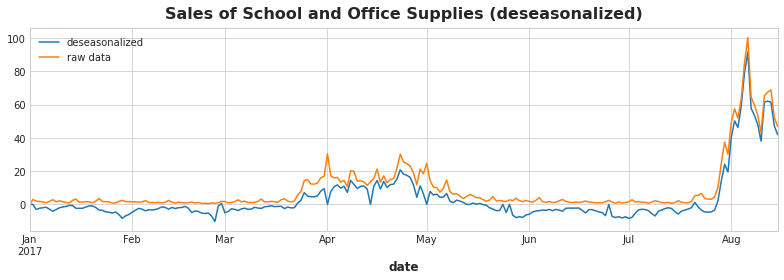

In [49]:
ax = y_resid_supply_sales.plot(label='deseasonalized')
y_supply_sales.plot(ax=ax, label='raw data')
ax.set_title("Sales of School and Office Supplies (deseasonalized)");
ax.legend()

This behaviour becomes clearer when we perform a moving average. 

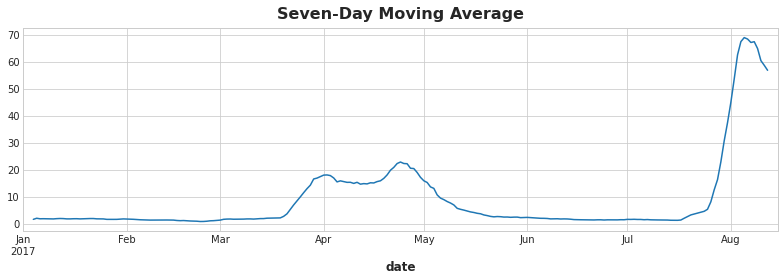

In [50]:
y_supply_sales_ma = y_supply_sales.rolling(
    window=7,       # 7-day window
    center=True,      # puts the average at the center of the window
).mean() 


# Plot
ax = y_supply_sales_ma.plot()
ax.set_title("Seven-Day Moving Average");

## Lag series/plots: Calculating (partial) autocorrelations

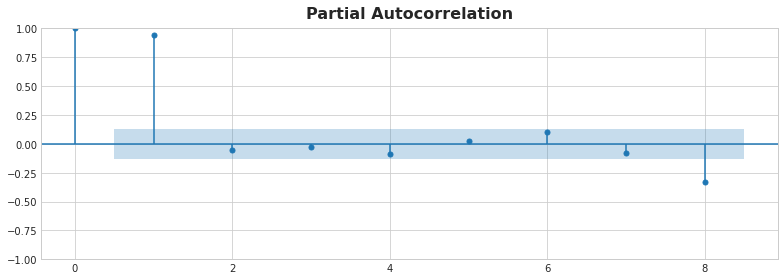

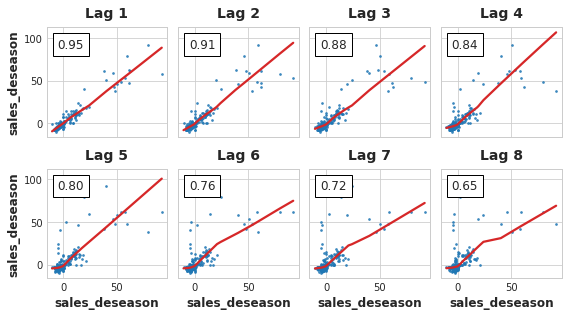

In [51]:
plot_pacf(y_resid_supply_sales, lags=8);
plot_lags(y_resid_supply_sales, lags=8, nrows=2);

From the autocorrelation plots and the partial autocorrelation calculations, it seems the first lag series is important (and also perhaps the 8th).

### Creating lag features

In [52]:
# Make features from `y_resid_supply_sales`
X_lags = make_lags(y_resid_supply_sales, lags=1)

In [53]:
X_supply_sales = pd.concat([X_time, X_lags], axis=1).dropna()
print(f"Total features in our combined feature set: {len(X_supply_sales.columns)}")

Total features in our combined feature set: 30


In [54]:
y_supply_sales, X_supply_sales = y_supply_sales.align(X_supply_sales, join='inner')

Training RMSLE: 0.43198
Validation RMSLE: 0.24564


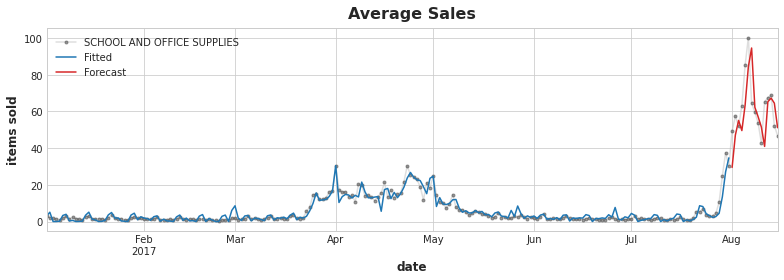

In [55]:
X_train_supply_sales, X_valid_supply_sales, y_train_supply_sales, y_valid_supply_sales = train_test_split(X_supply_sales, y_supply_sales, test_size=15, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train_supply_sales, y_train_supply_sales)
y_fit_supply_sales = pd.Series(model.predict(X_train_supply_sales), index=X_train_supply_sales.index).clip(0.0)
y_pred_supply_sales = pd.Series(model.predict(X_valid_supply_sales), index=X_valid_supply_sales.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train_supply_sales, y_fit_supply_sales) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid_supply_sales, y_pred_supply_sales) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y_supply_sales.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit_supply_sales.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred_supply_sales.plot(ax=ax, label="Forecast", color='C3')
ax.legend();

## Leading indicator: 'onpromotion'

A leading indicator provides "advance notice" of changes in the target. For our purpose, we can use the 'onpromotion' series in the training data. We load it in the same way as the 'store_sales' dataset [here](https://www.kaggle.com/code/abhirupghosh184098/store-sales-forecasting-a-comprehensive-guide#Preliminaries); and restrict ourselves to 2017 data for just the 'SCHOOL AND OFFICE SUPPLIES' family; and dividing between training and validation promotions.

In [56]:
y_supply_onpromotion = supply_sales.loc[:, 'onpromotion'].squeeze()
y_supply_onpromotion

date
2017-01-01    0.000000
2017-01-02    0.000000
2017-01-03    0.000000
2017-01-04    0.000000
2017-01-05    0.000000
                ...   
2017-08-11    2.666667
2017-08-12    2.759259
2017-08-13    2.777778
2017-08-14    2.851852
2017-08-15    2.740741
Freq: D, Name: SCHOOL AND OFFICE SUPPLIES, Length: 227, dtype: float64

In order to understand the impact of promotional campaigns on sales, we shift the onpromotion series forward and backward in relation to the sales time series (by 3 steps each). We find a higher correlation on leading series, as is expected intuitively. A promotion's effect on sales is only forward in time.

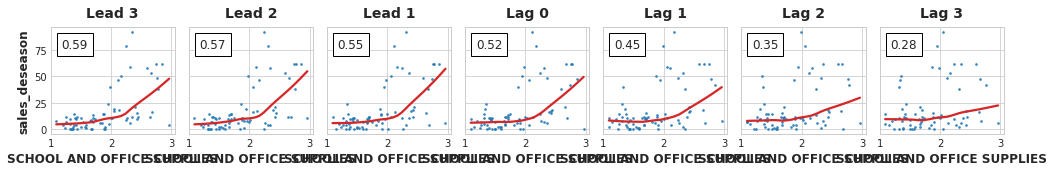

In [57]:
# Drop days without promotions
plot_lags(x=y_supply_onpromotion.loc[y_supply_onpromotion > 1], y=y_resid_supply_sales.loc[y_supply_onpromotion > 1], lags=3, leads=3, nrows=1);

### Creating leading indicator (onpromotion) features

In [58]:
X_promo = pd.concat([
    make_lags(y_supply_onpromotion, lags=1),
    y_supply_onpromotion,
    make_leads(y_supply_onpromotion, leads=1),
], axis=1)

We combine our time and serial (lags and leading indicators) dependence feature sets into one.

In [59]:
X_supply_sales = pd.concat([X_time, X_lags, X_promo], axis=1).dropna()
print(f"Total features in our combined feature set: {len(X_supply_sales.columns)}")

Total features in our combined feature set: 33


In [60]:
y_supply_sales, X_supply_sales = y_supply_sales.align(X_supply_sales, join='inner')

Training RMSLE: 0.37214
Validation RMSLE: 0.31150


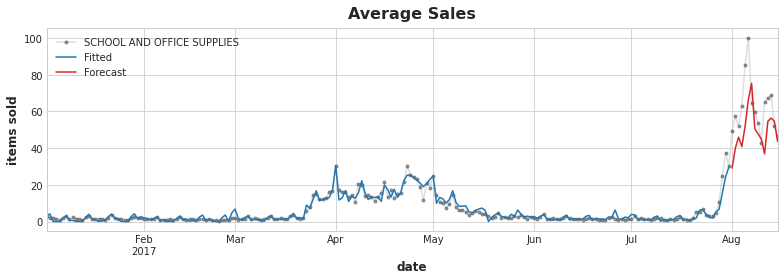

In [61]:
X_train_supply_sales, X_valid_supply_sales, y_train_supply_sales, y_valid_supply_sales = train_test_split(X_supply_sales, y_supply_sales, test_size=15, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train_supply_sales, y_train_supply_sales)
y_fit_supply_sales = pd.Series(model.predict(X_train_supply_sales), index=X_train_supply_sales.index).clip(0.0)
y_pred_supply_sales = pd.Series(model.predict(X_valid_supply_sales), index=X_valid_supply_sales.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train_supply_sales, y_fit_supply_sales) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid_supply_sales, y_pred_supply_sales) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y_supply_sales.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit_supply_sales.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred_supply_sales.plot(ax=ax, label="Forecast", color='C3')
ax.legend();

## Short Recap: What have we done up till this point?
* found cyclic behaviour in deseasonalised data
* created lag features based on (partial) autocorrelation
* created feature based on leading indicator (onpromotion) and its lags/leads
* combined them with time-dependence feature set to create one feature set
* used a linear algorithm to make train and validate

## Caveats:
The above analysis focussed on **one family** and **average sales across all stores**. In reality, our submission would require us to have sales for each family at each store, across all families and stores. Hence, we need to take a generalised way to predicting the stores sales.

## Next steps
* Combine time and serial dependence (linear/non-linear) using hybrid models
* Extend to all families of products
* Include information about store numbers
* Forecast lag features for test set

## Temporary digression

At this point we digress to do two things:
* explore how we can build hybrid models to separately explore time and serial dependence

For this next assumption, we are temporarily going to restrict ourselves to leading indicators (not its leads/lags) while modelling serial dependence and not include lag features. We will come back to this in the last segment where we make forecasts for machine learning following the tutorial [here](https://www.kaggle.com/code/ryanholbrook/forecasting-with-machine-learning).

# Combining Time and Serial dependence: Hybrid Models

An accurate prediction must incorporate accurate time-dependent and time-independent (serial-dependent) modelling. It often makes sense to break the predictions into two separate steps:
* Step 1: where we model out the time-dependence through incorporating trends, seasonality and seasonal indicators like holidays
* Step 2: look for serial dependence in the residuals

Step 2 itself can be based on linear modelling (restricted to the calculation of partial autocorrelation functions) or non-linear through algorithms like XGBoost or KNeighbors. A nice outline of combining time and serial dependence modelling using residuals is provided [here](https://www.kaggle.com/code/ryanholbrook/hybrid-models/tutorial#Hybrid-Forecasting-with-Residuals). The basic schema includes:
​
```
# 1. Train and predict with first model
model_1.fit(X_train_1, y_train)
y_pred_1 = model_1.predict(X_train)
​
# 2. Train and predict with second model on residuals
model_2.fit(X_train_2, y_train - y_pred_1)
y_pred_2 = model_2.predict(X_train_2)
​
# 3. Add to get overall predictions
y_pred = y_pred_1 + y_pred_2
```

**The second model `model_2` that we apply on the residuals would determine whether we incorporate non-linear effects (using an algorithm like XGBoost) or restrict ourselves to linear effects (w/ an algorithm like LinearRegression) as above. For the hybrid model below, we use KNeighbors.**

## Important assumptions in this section

We have so far been following a pattern of building up our model one step at a time, and in that regard, each section has build on from the previous one. However, for this section, we are going to break from tradition in the following ways:
* **For our serial-dependence features, we will only assume leading indicators, i.e., the 'onpromotion' column, and not make lag features.** We will come back to this in the last segment where we make forecasts for machine learning following the tutorial [here](https://www.kaggle.com/code/ryanholbrook/forecasting-with-machine-learning).
* We will directly use a non-linear algorithm, KNeighbors for modeeling the serial dependence
* The implementation of the hybrid model in this section also differs from the tutorial in that we **don't average out over store numbers, but retain them**, since we will need them for the submissions.

## Time-dependence

We had spent some time exploring time-dependence earlier in this analysis and at the end of the section, stored our entire feature set as: 'X_time' and 'X_time_test'. We load them back here:

In [62]:
# X_1: Time-dependence features

X_1 = X_time # training set time-features
X_1_test = X_time_test # test set time-features

# Splitting between training and validation sets

X_1_train, X_1_valid, y_train, y_valid = train_test_split(X_1, y, test_size=15, shuffle=False)

# Model 1: Ridge()

model_1 = Ridge().fit(X_1_train, y_train)

y_fit_1 = pd.DataFrame(model_1.predict(X_1_train), index=X_1_train.index, columns=y_train.columns).clip(0.0)
y_pred_1 = pd.DataFrame(model_1.predict(X_1_valid), index=X_1_valid.index, columns=y_valid.columns).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit_1) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred_1) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

Training RMSLE: 0.59491
Validation RMSLE: 0.56865


**NOTE**: Throughout this section, we use the letters 1 and 2 to refer to steps 1 (time-dependence) and 2 (serial-dependence) above.

## Serial Dependence

In [63]:
# X_2: Features for serial dependence
# onpromotion feature as a boolean variable
X_2 = store_sales.unstack(['store_nbr', 'family']).loc["2017"].loc[:, 'onpromotion']

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

# Splitting between training and validation sets
X_2_train, X_2_valid, y_train, y_valid = train_test_split(X_2, y, test_size=15, shuffle=False)

# Model 2: KNeighborsRegressor
model_2 = KNeighborsRegressor().fit(X_2_train, y_train - y_fit_1)

y_fit_2 = pd.DataFrame(model_2.predict(X_2_train), index=X_2_train.index, columns=y_train.columns).clip(0.0)
y_pred_2 = pd.DataFrame(model_2.predict(X_2_valid), index=X_2_valid.index, columns=y_valid.columns).clip(0.0)

y_fit = y_fit_1 + y_fit_2
y_pred = y_pred_1 + y_pred_2

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

Training RMSLE: 0.59272
Validation RMSLE: 0.58409


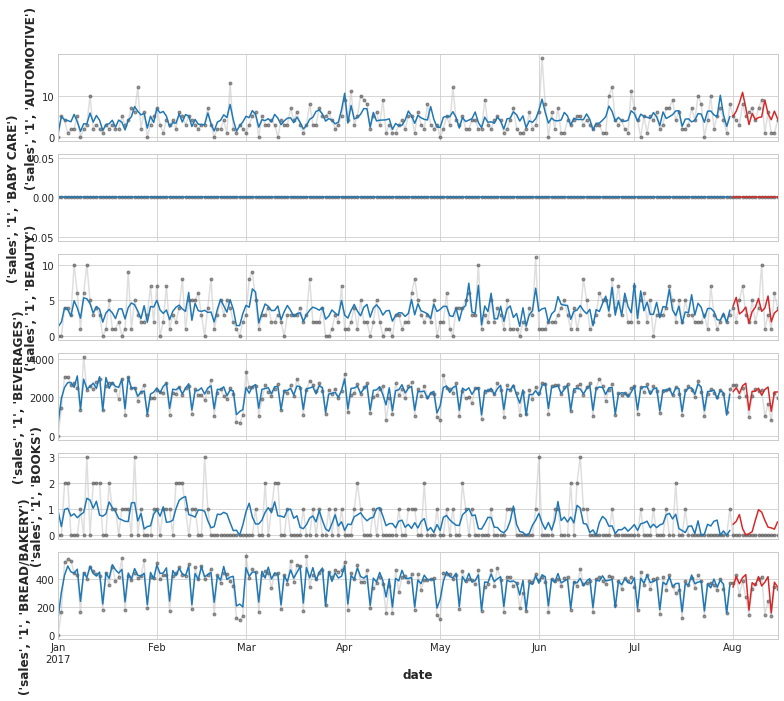

In [64]:
families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

## Making a BoostedHybrid class

In [65]:
class BoostedHybrid:
    
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method
        
def fit(self, X_1, X_2, y):
    # Train model_1
    self.model_1.fit(X_1, y)

    # Make predictions
    y_fit = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=y.columns,
    )

    # Compute residuals
    y_resid = y - y_fit

    # Train model_2 on residuals
    self.model_2.fit(X_2, y_resid)

    # Save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid


# Add method to class
BoostedHybrid.fit = fit

def predict(self, X_1, X_2):
    # Predict with model_1
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=self.y_columns,
    )

    # Add model_2 predictions to model_1 predictions
    y_pred += self.model_2.predict(X_2)

    return y_pred


# Add method to class
BoostedHybrid.predict = predict

In [66]:
model = BoostedHybrid(
    model_1=Ridge(fit_intercept=False),
    model_2=KNeighborsRegressor(),
)

model.fit(X_1_train, X_2_train, y_train)
y_fit = model.predict(X_1_train, X_2_train).clip(0.0)
y_pred = model.predict(X_1_valid, X_2_valid).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

Training RMSLE: 0.52119
Validation RMSLE: 0.61597


### Fourth Submission: BoostedHybrid using linear time-dependence + non-linear (leading-indicator-only) serial dependence

In [67]:
# X_1_test: Time-dependence features: test set

# X_2_test: Serial-dependence features: test set
X_2_test = df_test.unstack(['store_nbr', 'family']).loc["2017"].loc[:, 'onpromotion']

# Label encoding for seasonality
X_2_test["day"] = X_2_test.index.day  # values are day of the month

# making submission predictions
y_submit = model.predict(X_1_test, X_2_test).clip(0.0)
y_submit = pd.DataFrame(y_submit.stack(['store_nbr', 'family']))#.rename('sales'))
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission_hybrid.csv', index=False)
y_submit

id        sales
date       store_nbr family                                          
2017-08-16 1         AUTOMOTIVE                  3000888     4.483819
                     BABY CARE                   3000889     0.000000
                     BEAUTY                      3000890     4.491409
                     BEVERAGES                   3000891  2381.490724
                     BOOKS                       3000892     0.297855
...                                                  ...          ...
2017-08-31 9         POULTRY                     3029395   375.548750
                     PREPARED FOODS              3029396   101.343416
                     PRODUCE                     3029397  1275.181286
                     SCHOOL AND OFFICE SUPPLIES  3029398     4.827670
                     SEAFOOD                     3029399    18.404227

[28512 rows x 2 columns]

### [Public Score: 0.59726](https://www.kaggle.com/code/abhirupghosh184098/ts-forecasting-a-beginner-s-handbook?scriptVersionId=112684473)

The performance is actually marginally worse that using just time-dependence. This is not shocking. The only information we have added to time-dependence is promotion information and used it to model the entire residuals. However, the positive point is that we now have a hybrid model and we have extended it include store information as well in our predictions.

We will now move onto our last section where we will:
* create a complete X_2 feature set for all families and store numbers using a complete list of lag/lead features (+ leading indicators) + categorical day of week
* create a X_2_test features to be able to forecast using these lag features
* make one last prediction

# Forecast using Machine Learning

This last section of the analysis aims at bringing together all the concepts we have accummulated so far (modelling time-dependence through trends, seasonality and indicators, and serial dependence through lag series and leading indicators; exploring linear and non-linear effects in the data through a multi-staged residuals analysis, and so on) in making a forecast for the Grocery-sales dataset. This section derives heavily from two pieces of work:

* Lessons [5](https://www.kaggle.com/code/ryanholbrook/hybrid-models) and [6](https://www.kaggle.com/code/ryanholbrook/forecasting-with-machine-learning) from Ryan Holbrook's [time series course](https://www.kaggle.com/learn/time-series).
* [FilterJoe](https://www.kaggle.com/filterjoe)'s [(unofficial) Time Series Bonus Lesson](https://www.kaggle.com/code/filterjoe/time-series-bonus-lesson-unofficial)

As [FilterJoe](https://www.kaggle.com/filterjoe) mentions at the very beginning of his notebook:

> "Implementing Time Series lessons 5 and 6 on the competition data set is hard, as many of you have discovered. So hard, that few of us have done it. A bonus lesson could be helpful. This is that bonus lesson."

So a special shoutout to him for this valuable resource.

Also, by this point, this notebook is quite long, and it would make sense to do some of things we have done before again, just so that we don't need to keep referring back to them from earlier sections.

## Store sales data (again)

In [68]:
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32', ## NEW FEATURE: To be introduced later
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

## Training/Validation Range (again)

* Training range: 2017-01-01 -- 2017-07-31
* Validation range: 2017-07-31 -- 2017-08-15
* Test range: 2017-08-16 -- 2017-08-31

In [69]:
store_sales_train = store_sales.unstack(['store_nbr', 'family']).loc['2017':'2017-07-31']
store_sales_valid = store_sales.unstack(['store_nbr', 'family']).loc['2017-08-01':]

### Target: sales

In [70]:
y_train = store_sales_train.loc[:, 'sales']
y_val = store_sales_valid.loc[:, 'sales']

## Hybrid model (again)

In [71]:
# Credit: https://www.kaggle.com/code/filterjoe/time-series-bonus-lesson-unofficial

class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None
        self.stack_cols = None
        self.y_resid = None

    def fit1(self, X_1, y, stack_cols=None):
        self.model_1.fit(X_1, y) # train model 1
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1), # predict from model 1
            index=X_1.index,
            columns=y.columns,
        )
        self.y_resid = y - y_fit # residuals from model 1, which X2 may want to access to create lag (or other) features
        self.y_resid = self.y_resid.stack(stack_cols).squeeze()  # wide to long
        
    def fit2(self, X_2, first_n_rows_to_ignore, stack_cols=None):
        self.model_2.fit(X_2.iloc[first_n_rows_to_ignore*1782: , :], self.y_resid.iloc[first_n_rows_to_ignore*1782:]) # Train model_2
        self.y_columns = y.columns # Save for predict method
        self.stack_cols = stack_cols # Save for predict method

    def predict(self, X_1, X_2, first_n_rows_to_ignore):
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1.iloc[first_n_rows_to_ignore: , :]),
            index=X_1.iloc[first_n_rows_to_ignore: , :].index,
            columns=self.y_columns,
        )
        y_pred = y_pred.stack(self.stack_cols).squeeze()  # wide to long
#         display(X_2.iloc[first_n_rows_to_ignore*1782: , :]) # uncomment when debugging
        y_pred += self.model_2.predict(X_2.iloc[first_n_rows_to_ignore*1782: , :]) # Add model_2 predictions to model_1 predictions
        return y_pred.unstack(self.stack_cols)

### Defining our models

In [72]:
mod_1 = LinearRegression() # for time-dependence
mod_2 = XGBRegressor() # for serial-dependence

model = BoostedHybrid(model_1=mod_1, model_2=mod_2)

## Time-dependence (again)

### Creating X_1_train features

In [73]:
# Trends/Seasonality
# Fourier features
fourier = CalendarFourier(freq='M', order=4) ## 2 pairs of sine/cosine curves to model monthly/biweekly seasonality
dp = DeterministicProcess(
    index=y_train.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # cubic trend
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_1_train = dp.in_sample()

# Seasonal indicators: Holidays
X_1_train = X_1_train.join(X_holidays, on='date').fillna(0.0)

### Training time-dependence with X_1_train features

In [74]:
model.fit1(X_1_train, y_train, stack_cols=['store_nbr', 'family'])

## Complete X_2_train (serial dependence features)

### Creating features for leading indicator: 'onpromotion'

As we had noted earlier, the information already provided to us to anticipate and predict cycles is the **leading indicator 'onpromotion'**. Hence, we start with isolating that information.

In [75]:
on_promotions = store_sales_train.drop('sales', axis=1).stack(['store_nbr', 'family'])
on_promotions

onpromotion
date       store_nbr family                                 
2017-01-01 1         AUTOMOTIVE                            0
                     BABY CARE                             0
                     BEAUTY                                0
                     BEVERAGES                             0
                     BOOKS                                 0
...                                                      ...
2017-07-31 9         POULTRY                               1
                     PREPARED FOODS                        0
                     PRODUCE                               6
                     SCHOOL AND OFFICE SUPPLIES            6
                     SEAFOOD                               0

[377784 rows x 1 columns]

In [76]:
# Source: https://www.kaggle.com/code/filterjoe/time-series-bonus-lesson-unofficial

# create feature set X2 for hybrid model 2, including helper functions

# as lesson 5 suggests, X2 features can be anything,
# allowing an algorithm weak on trends but strong on detecting relationships among variables
# to further refine the modeling and forecasting

def encode_categoricals(df, columns):
    le = LabelEncoder()  # from sklearn.preprocessing
    for col in columns:
        df[col] = le.fit_transform(df[col])
    return df

def make_X2_lags(ts, lags, lead_time=1, name='y', stack_cols=None):
    ts = ts.unstack(stack_cols)
    df = pd.concat(
        {
            f'{name}_lag_{i}': ts.shift(i, freq="D") # freq adds i extra day(s) to end: only one extra day is needed so rest will be dropped
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)
    df = df.stack(stack_cols).reset_index()
    df = encode_categoricals(df, stack_cols)
    df = df.set_index('date').sort_values(by=stack_cols) # return sorted so can correctly compute rolling means (if desired)
    return df

In [77]:
# Source: https://www.kaggle.com/code/filterjoe/time-series-bonus-lesson-unofficial

# promo_lag features
shifted_promo_df = make_X2_lags(on_promotions.squeeze(), lags=2, name='promo', stack_cols=['store_nbr', 'family'])
shifted_promo_df['promo_mean_rolling_7'] = shifted_promo_df['promo_lag_1'].rolling(window=7, center=False).mean()
shifted_promo_df['promo_median_rolling_91'] = shifted_promo_df['promo_lag_1'].rolling(window=91, center=False).median().fillna(method='bfill')
shifted_promo_df['promo_median_rolling_162'] = shifted_promo_df['promo_lag_1'].rolling(window=162, center=False).median().fillna(method='bfill')
# for rolling window medians, backfilling seems reasonable as medians shouldn't change too much. Trying min_periods produced wacky (buggy?) results
shifted_promo_df

,store_nbr,family,promo_lag_1,promo_lag_2,promo_mean_rolling_7,promo_median_rolling_91,promo_median_rolling_162
date,,,,,,,
2017-01-02,0,0,0.0,NaN,NaN,0.0,0.0
2017-01-03,0,0,0.0,0.0,NaN,0.0,0.0
2017-01-04,0,0,0.0,0.0,NaN,0.0,0.0
2017-01-05,0,0,0.0,0.0,NaN,0.0,0.0
2017-01-06,0,0,0.0,0.0,NaN,0.0,0.0
...,...,...,...,...,...,...,...
2017-07-29,53,32,0.0,0.0,1.142857,0.0,0.0
2017-07-30,53,32,4.0,0.0,1.142857,0.0,0.0
2017-07-31,53,32,0.0,4.0,1.000000,0.0,0.0


### Creating features for lag series

For this, we need the residuals. This is because, when we explore serial dependence, we first factor out time-dependence and look for non-linear effects in the residuals.

In [78]:
y_resid_1 = model.y_resid
y_resid_1

date        store_nbr  family                    
2017-01-01  1          AUTOMOTIVE                    6.661338e-15
                       BABY CARE                     0.000000e+00
                       BEAUTY                        7.549517e-15
                       BEVERAGES                     4.092726e-12
                       BOOKS                         2.220446e-15
                                                         ...     
2017-07-31  9          POULTRY                       3.937835e+01
                       PREPARED FOODS               -5.022948e+01
                       PRODUCE                       1.720595e+01
                       SCHOOL AND OFFICE SUPPLIES    4.618259e+01
                       SEAFOOD                      -5.234851e+00
Length: 377784, dtype: float64

In [79]:
# Source: https://www.kaggle.com/code/filterjoe/time-series-bonus-lesson-unofficial

# y_lag features
shifted_y_df = make_X2_lags(y_resid_1, lags=2, name='y_res', stack_cols=['store_nbr', 'family'])
shifted_y_df['y_mean_rolling_7'] = shifted_y_df['y_res_lag_1'].rolling(window=7, center=False).mean()
shifted_y_df['y_mean_rolling_14'] = shifted_y_df['y_res_lag_1'].rolling(window=14, center=False).mean()
shifted_y_df['y_mean_rolling_28'] = shifted_y_df['y_res_lag_1'].rolling(window=28, center=False).mean()
shifted_y_df['y_median_rolling_91'] = shifted_y_df['y_res_lag_1'].rolling(window=91, center=False).median().fillna(method='bfill')
shifted_y_df['y_median_rolling_162'] = shifted_y_df['y_res_lag_1'].rolling(window=162, center=False).median().fillna(method='bfill')
shifted_y_df

,store_nbr,family,y_res_lag_1,y_res_lag_2,y_mean_rolling_7,y_mean_rolling_14,y_mean_rolling_28,y_median_rolling_91,y_median_rolling_162
date,,,,,,,,,
2017-01-02,0,0,6.661338e-15,NaN,NaN,NaN,NaN,-1.930712e-01,-1.605919e-01
2017-01-03,0,0,-3.552714e-15,6.661338e-15,NaN,NaN,NaN,-1.930712e-01,-1.605919e-01
2017-01-04,0,0,-9.597850e-02,-3.552714e-15,NaN,NaN,NaN,-1.930712e-01,-1.605919e-01
2017-01-05,0,0,-2.980515e+00,-9.597850e-02,NaN,NaN,NaN,-1.930712e-01,-1.605919e-01
2017-01-06,0,0,-1.722867e+00,-2.980515e+00,NaN,NaN,NaN,-1.930712e-01,-1.605919e-01
...,...,...,...,...,...,...,...,...,...
2017-07-29,53,32,-3.283010e+00,-2.675992e+00,-1.362002,-2.279084,-2.676119,-2.842171e-14,-2.842171e-14
2017-07-30,53,32,-3.502559e+00,-3.283010e+00,-2.178977,-2.976125,-2.980308,-6.173758e-03,-2.842171e-14
2017-07-31,53,32,-5.279825e+00,-3.502559e+00,-1.658073,-2.781064,-3.399490,-6.173758e-03,-2.842171e-14


### Other Features

In [80]:
# Source: https://www.kaggle.com/code/filterjoe/time-series-bonus-lesson-unofficial

X_2_train = encode_categoricals(on_promotions.reset_index(['store_nbr', 'family']),columns=['store_nbr', 'family'])
X_2_train["day_of_w"] = X_2_train.index.dayofweek # does absolutely nothing alone
X_2_train = encode_categoricals(X_2_train, ["day_of_w"])
X_2_train['wage_day'] = (X_2_train.index.day == X_2_train.index.daysinmonth) | (X_2_train.index.day == 15) # is it bad to have this in both X1 AND X2?
X_2_train['wage_day_lag_1'] = (X_2_train.index.day == 1) | (X_2_train.index.day == 16)
X_2_train['promo_mean'] = X_2_train.groupby(['store_nbr', 'family'])['onpromotion'].transform("mean") + 0.000001
X_2_train['promo_ratio'] = X_2_train.onpromotion / (X_2_train.groupby(['store_nbr', 'family'])['onpromotion'].transform("mean") + 0.000001)
X_2_train

,store_nbr,family,onpromotion,day_of_w,wage_day,wage_day_lag_1,promo_mean,promo_ratio
date,,,,,,,,
2017-01-01,0,0,0,6,False,True,0.000001,0.000000
2017-01-01,0,1,0,6,False,True,0.000001,0.000000
2017-01-01,0,2,0,6,False,True,0.471699,0.000000
2017-01-01,0,3,0,6,False,True,24.108492,0.000000
2017-01-01,0,4,0,6,False,True,0.000001,0.000000
...,...,...,...,...,...,...,...,...
2017-07-31,53,28,1,0,True,False,3.160378,0.316418
2017-07-31,53,29,0,0,True,False,1.372643,0.000000
2017-07-31,53,30,6,0,True,False,25.429246,0.235949


### Combining the feature sets to form one serial-dependence feature set

In [81]:
# Source: https://www.kaggle.com/code/filterjoe/time-series-bonus-lesson-unofficial

X_2_train = X_2_train.merge(shifted_y_df, on=['date', 'store_nbr', 'family'], how='left')
X_2_train = X_2_train.merge(shifted_promo_df, on=['date', 'store_nbr', 'family'], how='left') # merges work if they are last line before return
X_2_train

,store_nbr,family,onpromotion,day_of_w,wage_day,wage_day_lag_1,promo_mean,promo_ratio,y_res_lag_1,y_res_lag_2,y_mean_rolling_7,y_mean_rolling_14,y_mean_rolling_28,y_median_rolling_91,y_median_rolling_162,promo_lag_1,promo_lag_2,promo_mean_rolling_7,promo_median_rolling_91,promo_median_rolling_162
date,,,,,,,,,,,,,,,,,,,,
2017-01-01,0,0,0,6,False,True,0.000001,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,0,1,0,6,False,True,0.000001,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,0,2,0,6,False,True,0.471699,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,0,3,0,6,False,True,24.108492,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,0,4,0,6,False,True,0.000001,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-31,53,28,1,0,True,False,3.160378,0.316418,-93.495963,-65.837788,-13.085678,-7.168563,-3.905400,-1.136868e-13,-5.993931e+00,1.0,0.0,3.285714,0.0,0.0
2017-07-31,53,29,0,0,True,False,1.372643,0.000000,-12.808013,2.361600,-13.484798,-12.997190,-6.317569,2.089393e+00,1.985813e+00,1.0,1.0,0.857143,0.0,0.0
2017-07-31,53,30,6,0,True,False,25.429246,0.235949,-282.028748,55.369720,53.227004,19.239565,37.100573,1.467949e+01,-2.273737e-13,7.0,8.0,31.285714,6.0,6.0


Before moving on, we make a function to make the X_2 features, just like [here](https://www.kaggle.com/code/filterjoe/time-series-bonus-lesson-unofficial#Creating-X2-Features).

In [82]:
def make_X2_features(df, y_resid):
    stack_columns = ['store_nbr', 'family']
    
    # promo_lag features
    shifted_promo_df = make_X2_lags(df.squeeze(), lags=2, name='promo', stack_cols=['store_nbr', 'family'])
    shifted_promo_df['promo_mean_rolling_7'] = shifted_promo_df['promo_lag_1'].rolling(window=7, center=False).mean()
    shifted_promo_df['promo_median_rolling_91'] = shifted_promo_df['promo_lag_1'].rolling(window=91, center=False).median().fillna(method='bfill')
    shifted_promo_df['promo_median_rolling_162'] = shifted_promo_df['promo_lag_1'].rolling(window=162, center=False).median().fillna(method='bfill')
    # for rolling window medians, backfilling seems reasonable as medians shouldn't change too much. Trying min_periods produced wacky (buggy?) results
    
    # y_lag features
    shifted_y_df = make_X2_lags(y_resid, lags=2, name='y_res', stack_cols=stack_columns)
    shifted_y_df['y_mean_rolling_7'] = shifted_y_df['y_res_lag_1'].rolling(window=7, center=False).mean()
    shifted_y_df['y_median_rolling_91'] = shifted_y_df['y_res_lag_1'].rolling(window=91, center=False).median().fillna(method='bfill')
    shifted_y_df['y_median_rolling_162'] = shifted_y_df['y_res_lag_1'].rolling(window=162, center=False).median().fillna(method='bfill')
    
    # other features
    df = df.reset_index(stack_columns)
    X2 = encode_categoricals(df, stack_columns)
    
    X2["day_of_w"] = X2.index.dayofweek # does absolutely nothing alone
    X2 = encode_categoricals(df, ['day_of_w'])
    
    X2['wage_day'] = (X2.index.day == X2.index.daysinmonth) | (X2.index.day == 15) # is it bad to have this in both X1 AND X2?
    X2['wage_day_lag_1'] = (X2.index.day == 1) | (X2.index.day == 16)
    X2['promo_mean'] = X2.groupby(['store_nbr', 'family'])['onpromotion'].transform("mean") + 0.000001
    X2['promo_ratio'] = X2.onpromotion / (X2.groupby(['store_nbr', 'family'])['onpromotion'].transform("mean") + 0.000001)

    # combing into one feature set
    X2 = X2.merge(shifted_y_df, on=['date', 'store_nbr', 'family'], how='left')
    X2 = X2.merge(shifted_promo_df, on=['date', 'store_nbr', 'family'], how='left') # merges work if they are last line before return
    return X2

X_2_train = make_X2_features(store_sales_train
                           .drop('sales', axis=1)
                           .stack(['store_nbr', 'family']),
                           model.y_resid)

X_2_train

,store_nbr,family,onpromotion,day_of_w,wage_day,wage_day_lag_1,promo_mean,promo_ratio,y_res_lag_1,y_res_lag_2,y_mean_rolling_7,y_median_rolling_91,y_median_rolling_162,promo_lag_1,promo_lag_2,promo_mean_rolling_7,promo_median_rolling_91,promo_median_rolling_162
date,,,,,,,,,,,,,,,,,,
2017-01-01,0,0,0,6,False,True,0.000001,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,0,1,0,6,False,True,0.000001,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,0,2,0,6,False,True,0.471699,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,0,3,0,6,False,True,24.108492,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,0,4,0,6,False,True,0.000001,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-31,53,28,1,0,True,False,3.160378,0.316418,-93.495963,-65.837788,-13.085678,-1.136868e-13,-5.993931e+00,1.0,0.0,3.285714,0.0,0.0
2017-07-31,53,29,0,0,True,False,1.372643,0.000000,-12.808013,2.361600,-13.484798,2.089393e+00,1.985813e+00,1.0,1.0,0.857143,0.0,0.0
2017-07-31,53,30,6,0,True,False,25.429246,0.235949,-282.028748,55.369720,53.227004,1.467949e+01,-2.273737e-13,7.0,8.0,31.285714,6.0,6.0


## Modelling serial-dependence

Since we compute rolling (trailing) 7 day means based on lag_1, the first entry in time series is NaN. But since the next 6 are means based on <7 days, so the first 7 rows of the time series become NaNs, and hence need to be dropped. Consequently, we define a variable `max_lag = 7` to drop the first 7 rows.

In [83]:
max_lag = 7

In [84]:
model.fit2(X_2_train, max_lag, stack_cols=['store_nbr', 'family'])

In [85]:
y_fit = model.predict(X_1_train, X_2_train, max_lag).clip(0.0)

In [86]:
rmsle_train = mean_squared_log_error(y_train.iloc[7:], y_fit) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')

Training RMSLE: 0.47551


## Preparing data for forecasting

Unlike the previous submission steps, I have turned this one into a section of its own. This is because the data preparation for forecasting using serial dependence is distinctly different and more challenging than when we were using deterministic features like trends and seasonality to make predictions for the out-of-training-range test set dates.

As highlighted in the [tutorial](https://www.kaggle.com/code/ryanholbrook/forecasting-with-machine-learning), we could easily create forecasts for any time in the future by just generating our desired trend and seasonal features. However, when we added lag features, the nature of the problem changed. Lag features require that the lagged target value is known at the time being forecast. A lag 1 feature shifts the time series forward 1 step, which means you could forecast 1 step into the future but not 2 steps.

**Forecasting Strategy: Day-by-day Recursive w/ Fixed Past**

As the [tutorial](https://www.kaggle.com/code/ryanholbrook/forecasting-with-machine-learning#Multistep-Forecasting-Strategies) mentions, using the recursive strategy, we 

> train a single one-step model and use its forecasts to update the lag features for the next step. With the recursive method, we feed a model's 1-step forecast back in to that same model to use as a lag feature for the next forecasting step. We only need to train one model, but since errors will propagate from step to step, forecasts can be inaccurate for long horizons.


It can also be a slow process.

## Validation

In [87]:
# initialize y_pred_combined

y_pred_combined = y_fit.copy()

### Recursive forecasting

In [88]:
# Credit: https://www.kaggle.com/code/filterjoe/time-series-bonus-lesson-unofficial?scriptVersionId=80726243&cellId=36

validation_days = len(y_val)
val_start_day = datetime.datetime(2017, 8, 1)
val_end_day = datetime.datetime(2017, 8, 15)


# Create time-dependence features for validation set
# loop through forecast, one day ("step") at a time
dp_for_full_X1_val_date_range = dp.out_of_sample(steps=validation_days)
dp_for_full_X1_val_date_range.index.name = 'date'

for step in range(validation_days):
    
    dp_steps_so_far = dp_for_full_X1_val_date_range.loc[val_start_day:val_start_day+pd.Timedelta(days=step),:]
    X_1_combined_dp_data = pd.concat([dp.in_sample(), dp_steps_so_far])
    X_1_val = X_1_combined_dp_data.join(X_holidays, on='date').fillna(0.0)
    
    X_2_combined_data = pd.concat([store_sales_train,
                                       store_sales_valid.loc[val_start_day:val_start_day+pd.Timedelta(days=step), :]])
    
    X_2_val = make_X2_features(X_2_combined_data
                                    .drop('sales', axis=1)
                                    .stack(['store_nbr', 'family']),
                                    model.y_resid) # preparing X2 for hybrid part 2: XGBoost
    
    y_pred_combined = pd.concat([y_pred_combined,
                                     model.predict(X_1_val, X_2_val, max_lag).clip(0.0).iloc[-1:]
                                    ])
    y_plus_y_val = pd.concat([y_train, y_pred_combined.iloc[-(step+1):]]) # add newly predicted rows of y_pred_combined
    model.fit1(X_1_val, y_plus_y_val, stack_cols=['store_nbr', 'family']) # fit on new combined X, y - note that fit prior to val date range will change slightly
    model.fit2(X_2_val, max_lag, stack_cols=['store_nbr', 'family'])
    
    rmsle_valid = mean_squared_log_error(y_val.iloc[step:step+1], y_pred_combined.iloc[-1:]) ** 0.5
    print(f'Validation RMSLE: {rmsle_valid:.5f}', "for", val_start_day+pd.Timedelta(days=step))
    
y_pred = y_pred_combined[val_start_day:val_end_day]
display(y_pred)

Validation RMSLE: 0.58510 for 2017-08-01 00:00:00
Validation RMSLE: 0.54933 for 2017-08-02 00:00:00
Validation RMSLE: 0.54443 for 2017-08-03 00:00:00
Validation RMSLE: 0.49070 for 2017-08-04 00:00:00
Validation RMSLE: 0.45099 for 2017-08-05 00:00:00
Validation RMSLE: 0.48805 for 2017-08-06 00:00:00
Validation RMSLE: 0.54276 for 2017-08-07 00:00:00
Validation RMSLE: 0.59445 for 2017-08-08 00:00:00
Validation RMSLE: 0.55109 for 2017-08-09 00:00:00
Validation RMSLE: 0.54881 for 2017-08-10 00:00:00
Validation RMSLE: 0.56994 for 2017-08-11 00:00:00
Validation RMSLE: 0.52227 for 2017-08-12 00:00:00
Validation RMSLE: 0.51270 for 2017-08-13 00:00:00
Validation RMSLE: 0.52029 for 2017-08-14 00:00:00
Validation RMSLE: 0.57101 for 2017-08-15 00:00:00


store_nbr           1                                                          \
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-08-01   6.733055  0.886812  5.423476  2473.724093  2.131547   366.075906   
2017-08-02   5.236506  0.000000  6.779715  2604.762262  0.212557   429.989707   
2017-08-03   4.862699  0.000000  6.040893  2232.518867  0.000000   375.105217   
2017-08-04   6.447310  0.000000  5.639101  2540.283697  0.000000   396.578317   
2017-08-05   4.578589  0.000000  6.579297  2569.459276  0.000000   387.712191   
2017-08-06   1.615018  0.000000  4.787892   882.355504  0.000000   127.484068   
2017-08-07   4.084473  0.624574  8.036130  2309.537025  0.748605   381.336673   
2017-08-08   3.172047  0.000000  6.543543  2259.511656  0.264693   342.155895   
2017-08-09   3.729791  0.000000  6.702606  2397.355763  0.059693   406.740265   
2017-08-10   3.739197  0.000000  6.176525  2050.216139  0.000000   348.490939   
2017-08-11   6.065114  0.000000  5.815308  2395.711222  0.000000   369.380114   
2017-08-12   4.795029  0.000000  5.724753  2461.993449  0.000000   367.899149   
2017-08-13   1.968761  0.000000  0.989383   915.299062  0.000000   109.416563   
2017-08-14   4.570087  0.000000  6.465416  2304.122447  0.000000   364.015106   
2017-08-15   3.581911  0.000000  6.786623  2307.078389  0.000000   327.281106   

store_nbr                                                   ...         9  \
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
date                                                        ...             
2017-08-01   17.678182  820.475091  750.867008  158.273548  ...  3.294215   
2017-08-02   17.402985  928.990109  857.389800  153.775940  ...  2.170681   
2017-08-03   20.384305  750.949170  732.186357  129.717271  ...  1.095096   
2017-08-04   21.914202  835.526819  827.008589  197.378726  ...  0.916890   
2017-08-05   12.561415  692.728551  768.216145  144.313124  ...  1.597020   
2017-08-06    1.610528  266.074955  254.939620   59.655346  ...  2.850983   
2017-08-07   13.429216  701.810345  730.896999  144.087459  ...  1.133305   
2017-08-08   15.438459  785.658728  715.788434  135.963769  ...  1.165383   
2017-08-09   17.906384  868.726197  793.858658  137.789259  ...  2.774845   
2017-08-10   22.161759  683.446613  691.644261  114.065531  ...  3.170890   
2017-08-11   25.830188  743.626284  775.088152  160.926972  ...  4.283898   
2017-08-12   17.353438  612.041207  755.451096  135.166250  ...  5.473520   
2017-08-13    6.325294  195.053913  286.234824   55.130701  ...  6.190714   
2017-08-14   17.374049  642.369348  740.578305  143.732886  ...  3.540936   
2017-08-15   17.441402  734.544928  702.622871  136.429921  ...  2.330472   

store_nbr                                                                  \
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-08-01  414.658499    568.712517    10.327456               15.336932   
2017-08-02  408.898913    556.706791    10.393313               10.783525   
2017-08-03  605.667916    554.096894     8.176919                9.639118   
2017-08-04  357.750847    491.160100     8.396890                7.336635   
2017-08-05  463.714279    720.297612    10.390842               12.927745   
2017-08-06  461.666864    733.863171    10.253037               14.292990   
2017-08-07  358.047886    471.099468     5.851704                6.709870   
2017-08-08  330.716676    428.542685     4.595577                7.021297   
2017-08-09  307.206932    358.548718     6.504501                6.504262   
2017-08-10  497.299670    322.846403     4.857349                6.736151   
2017-08-11  259.009606    256.539221     6.291021                5.851407   
2017-08-12  381.215781    543.668066     9.487634               12.268217   

In [89]:
rmsle_train = mean_squared_log_error(y_train.iloc[max_lag: , :].clip(0.0), y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_val.clip(0.0), y_pred) ** 0.5
print()
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')
    
y_predict = y_pred.stack(['store_nbr', 'family']).reset_index()
y_target = y_val.stack(['store_nbr', 'family']).reset_index().copy()
y_target.rename(columns={y_target.columns[3]:'sales'}, inplace=True)
y_target['sales_pred'] = y_predict[0].clip(0.0) # Sales should be >= 0
y_target['store_nbr'] = y_target['store_nbr'].astype(int)

print('\nValidation RMSLE by family')
display(y_target.groupby('family').apply(lambda r: mean_squared_log_error(r['sales'], r['sales_pred'])))

print('\nValidation RMSLE by store')
display(y_target.sort_values(by="store_nbr").groupby('store_nbr').apply(lambda r: mean_squared_log_error(r['sales'], r['sales_pred'])))


Training RMSLE: 0.47551
Validation RMSLE: 0.53746

Validation RMSLE by family


family
AUTOMOTIVE                    0.296795
BABY CARE                     0.118025
BEAUTY                        0.293625
BEVERAGES                     0.069071
BOOKS                         0.049869
BREAD/BAKERY                  0.043810
CELEBRATION                   0.366743
CLEANING                      0.154795
DAIRY                         0.038223
DELI                          0.043558
EGGS                          0.103713
FROZEN FOODS                  0.382680
GROCERY I                     0.039572
GROCERY II                    0.422850
HARDWARE                      0.366966
HOME AND KITCHEN I            0.527737
HOME AND KITCHEN II           0.271595
HOME APPLIANCES               0.153183
HOME CARE                     0.055716
LADIESWEAR                    0.364954
LAWN AND GARDEN               0.319814
LINGERIE                      0.488976
LIQUOR,WINE,BEER              0.834302
MAGAZINES                     0.350191
MEATS                         0.055443
PERSONAL CARE     


Validation RMSLE by store


store_nbr
1     0.203761
2     0.158459
3     0.114338
4     0.158051
5     0.178419
6     0.118448
7     0.128338
8     0.143893
9     0.531976
10    0.248958
11    0.237106
12    0.230813
13    0.206322
14    0.312323
15    0.235392
16    0.335718
17    0.313283
18    0.272534
19    0.332689
20    0.428289
21    0.309955
22    0.296959
23    0.216426
24    0.146993
25    1.088941
26    0.283147
27    0.149786
28    0.259713
29    0.186515
30    0.266988
31    0.232158
32    0.341623
33    0.341977
34    0.335665
35    0.607210
36    0.470586
37    0.143289
38    0.232613
39    0.229284
40    0.386639
41    0.183475
42    0.175631
43    0.357329
44    0.449943
45    0.180393
46    0.156919
47    0.393052
48    0.580626
49    0.170748
50    0.654556
51    0.271149
52    0.149365
53    0.217994
54    0.241856
dtype: float64

## Test Set

Now, we repeat the entire procedure for the test set. The test set data looks like:

In [90]:
df_test.head()

id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08-17  3002670            0
                     2017-08-18  3004452            0
                     2017-08-19  3006234            0
                     2017-08-20  3008016            0

In [91]:
store_sales_test = df_test.unstack(['store_nbr', 'family']).drop('id', axis=1)
store_sales_test.head()

onpromotion                                                \
store_nbr            1                                                 
family      AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                   
2017-08-16           0         0      2        20     0           12   
2017-08-17           0         0      1        17     0            7   
2017-08-18           0         0      1        12     0           10   
2017-08-19           0         0      1        11     0            9   
2017-08-20           0         0      1        10     0            5   

                                            ...                                \
store_nbr                                   ...         9                       
family     CELEBRATION CLEANING DAIRY DELI  ... MAGAZINES MEATS PERSONAL CARE   
date                                        ...                                 
2017-08-16           0       25    45   18  ...         0     0            19   
2017-08-17           0        7    13    7  ...         0    21            10   
2017-08-18           0        6    18   52  ...         0     1             9   
2017-08-19           0       11    20    6  ...         0     1            11   
2017-08-20           0        4    17    6  ...         0     0            12   

                                                                        \
store_nbr                                                                
family     PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY PREPARED FOODS   
date                                                                     
2017-08-16            0                       0       0              1   
2017-08-17            0                       0       0              0   
2017-08-18            0                       0      14              2   
2017-08-19            0                       0       0              0   
2017-08-20            0                       0       1              0   

                                                       
store_nbr                                              
family     PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                   
2017-08-16     158                         14       0  
2017-08-17       1                         10       0  
2017-08-18       1                          6       0  
2017-08-19       1                          6       2  
2017-08-20       1                          8       0  

[5 rows x 1782 columns]

**Retraining over entire training and validation sets.** So we start again from the combined training store sales.

In [92]:
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32', ## NEW FEATURE: To be introduced later
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

store_sales = store_sales.unstack(['store_nbr', 'family']).loc['2017']
y = store_sales.loc[:, 'sales']

In [93]:
# model for testing
model_for_test = BoostedHybrid(model_1=mod_1, model_2=mod_2)

# Trends/Seasonality
# Fourier features
fourier = CalendarFourier(freq='M', order=4) ## 2 pairs of sine/cosine curves to model monthly/biweekly seasonality
dp_test = DeterministicProcess(
    index=y.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # cubic trend
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_1_train = dp_test.in_sample()

# Seasonal indicators: Holidays
X_1_train = X_1_train.join(X_holidays, on='date').fillna(0.0)

# fitting model 1 over entire training set sales: y
model_for_test.fit1(X_1_train, y, stack_cols=['store_nbr', 'family'])

# make X_2 features based on entire store_sales
# preparing X2 for hybrid part 2: XGBoost
X_2_train = make_X2_features(store_sales
                           .drop('sales', axis=1)
                           .stack(['store_nbr', 'family']),
                           model_for_test.y_resid)

# fitting model 2 over residuals of entire training set sales
model_for_test.fit2(X_2_train, max_lag, stack_cols=['store_nbr', 'family'])

# initializing with training set fit
y_forecast_combined = model_for_test.predict(X_1_train, X_2_train, max_lag).clip(0.0)

In [94]:
test_days = len(store_sales_test)
test_start_day = datetime.datetime(2017, 8, 16)
test_end_day = datetime.datetime(2017, 8, 31)


# Create time-dependence features for test set
# loop through forecast, one day ("step") at a time
dp_for_full_X1_test_date_range = dp_test.out_of_sample(steps=test_days)
dp_for_full_X1_test_date_range.index.name = 'date'

for step in range(test_days):
    
    dp_steps_so_far = dp_for_full_X1_test_date_range.loc[test_start_day:test_start_day+pd.Timedelta(days=step),:]
    X_1_combined_dp_data = pd.concat([dp_test.in_sample(), dp_steps_so_far])
    X_1_test = X_1_combined_dp_data.join(X_holidays, on='date').fillna(0.0)
    
    X_2_combined_data = pd.concat([store_sales,
                                       store_sales_test.loc[test_start_day:test_start_day+pd.Timedelta(days=step), :]])
    
    X_2_test = make_X2_features(X_2_combined_data
                                    .drop('sales', axis=1)
                                    .stack(['store_nbr', 'family']),
                                    model_for_test.y_resid) # preparing X2 for hybrid part 2: XGBoost
    
    y_forecast_combined = pd.concat([y_forecast_combined,
                                     model_for_test.predict(X_1_test, X_2_test, max_lag).clip(0.0).iloc[-1:]
                                    ])
    y_plus_y_test = pd.concat([y, y_forecast_combined.iloc[-(step+1):]]) # add newly predicted rows of y_forecast_combined
    model_for_test.fit1(X_1_test, y_plus_y_test, stack_cols=['store_nbr', 'family']) # fit on new combined X, y - note that fit prior to test date range will change slightly
    model_for_test.fit2(X_2_test, max_lag, stack_cols=['store_nbr', 'family'])
    
    print("finished forecast for", test_start_day+pd.Timedelta(days=step))

finished forecast for 2017-08-16 00:00:00
finished forecast for 2017-08-17 00:00:00
finished forecast for 2017-08-18 00:00:00
finished forecast for 2017-08-19 00:00:00
finished forecast for 2017-08-20 00:00:00
finished forecast for 2017-08-21 00:00:00
finished forecast for 2017-08-22 00:00:00
finished forecast for 2017-08-23 00:00:00
finished forecast for 2017-08-24 00:00:00
finished forecast for 2017-08-25 00:00:00
finished forecast for 2017-08-26 00:00:00
finished forecast for 2017-08-27 00:00:00
finished forecast for 2017-08-28 00:00:00
finished forecast for 2017-08-29 00:00:00
finished forecast for 2017-08-30 00:00:00
finished forecast for 2017-08-31 00:00:00


In [95]:
y_forecast = pd.DataFrame(y_forecast_combined[test_start_day:test_end_day].clip(0.0), columns=y.columns)

### Fifth submission: Hybrid time and (complete) serial dependence modelling + recursive forecasting

In [96]:
# making submission predictions

y_submit = y_forecast.stack(['store_nbr', 'family'])
y_submit = pd.DataFrame(y_submit, columns=['sales'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission_hybrid_recursive.csv', index=False)

# Our final model:
* restricts our training data to 2017
* models time-dependence through trends, monthly and bi-weekly Fourier features, day-of-the-week seasonal indicators and holiday features using a linear algorithm (LinearRegression)
* models serial-dependence lagged series of residuals, lead/lag series of leading indicators (onpromotion) and other statistical features using a non-linear algorithm (XGBoost)
* validates using the last 15 days of the full training set
* forecasts for the test set dates using a recursive strategy 

## [Final Public Score: 0.50109](https://www.kaggle.com/code/abhirupghosh184098/ts-forecasting-a-beginner-s-handbook?scriptVersionId=113116759)

# The future

Through this notebook, I tried focussed on aspects of a time-series and how they influence forecasting. I did not delve deep into core machine learning concepts like data cleaning, data wrangling, feature engineering and evaluation of the algorithms themselves. As I go through the Kaggle landscape, I have tried tackling each issue separately, so that each solution remains a dominant resource on only one aspect of machine learning. Having said that, there are a few things one could do to improve on the analysis presented here:

* engineering features other than those directly related to aspects of a time series
* focus on modelling by exploring the best choice of parameters (through hyper-parameter tuning) or evaluating the models themselves by seeing which model is best validated for our time-series forecasting
* and finally, use forecasting strategies other than the recursive strategy we have used here.

I hope you had fun reading this; and see you soon in another notebook. :)